# Spatial Statistics and Machine Learning -  Case Study: The Reprise of the Far Right
## Investigating Spatial Heterogeneity in Far-Right Voting Behaviour in the 2025 German Federal Elections

### Authors:
- Marion Späth		2772981
- Katia Tseliou		2500434
- Morgan Arima		9374752
- Joris Burger		0859427


### Research Questions: 
1. What factors influenced far-right voting behavior for the AfD in the 2025 German general elections?
2. To what extent does the explanatory power of different factors vary across space?

# PART 1:

The code in this notebook was used to collect the data as described in the Data chapter. Unfortunately, there were no easily usable APIs so the process couldnt be fully automated and we cannot share the separate source data files. Thus, the notebook can only be visually inspected or replicated by downloaded the respective files from the websites mentioned in the paper. 
We submitted two datasets which mirror the distribution of our tasks. The first "df_full_post_data_collection.gpkg" file contains the full dataset resulting from merging and interpolating the various source datasets as desribed below and in the paper. It is needed as the input for the GWR notebook. The second file "df_short_standardised.gpkg" is a shorter version of the first and only contains the standardised variables selected for the GWR and (S)RF. It is needed as the input of the (S)RF notbook.

In [140]:
import os
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patheffects import withStroke
from matplotlib.transforms import blended_transform_factory
from matplotlib.patches import FancyArrowPatch
from matplotlib import cm

from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import gdown

import libpysal as lps
from libpysal.weights import Queen
import esda
from esda.moran import Moran_Local

## Download and import Data (Shapefiles and Raster data)

In [ ]:
# Set the base path for all data files
BASE_PATH = "/content/sample_data"

# Define paths
shapefiles = {
    "constituencies": os.path.join(BASE_PATH, "btw25_geometrie_wahlkreise_vg250_shp_geo.shp"),
    "disposable_income": os.path.join(BASE_PATH, "disposable_income.shp"),
    "proportion_agriculture": os.path.join(BASE_PATH, "proportion_agriculture.shp"),
    "proportion_residential_transport": os.path.join(BASE_PATH, "proportion_residential_transport.shp"),
    "unemployment_rate": os.path.join(BASE_PATH, "unemployment_rate.shp")
}

csv_files = {
    "election_results": os.path.join(BASE_PATH, "results_btw25.csv"),
    "population_count": os.path.join(BASE_PATH, "Zensus2022_population_count_1km-Gitter.csv"),
    "prop_foreigners": os.path.join(BASE_PATH, "Zensus2022_proportion_foreigners_1km-Gitter.csv"),
    "avg_age": os.path.join(BASE_PATH, "Zensus2022_avg_age_1km-Gitter.csv"),
    "age_5cats": os.path.join(BASE_PATH, "Zensus2022_age_5_categories_1km-Gitter.csv"),
    "avg_rent_cold": os.path.join(BASE_PATH, "Zensus2022_avg_rent_cold_1km-Gitter.csv"),
    "prop_houseowners": os.path.join(BASE_PATH, "Zensus2022_prop_houseowners_1km-Gitter.csv"),
    "avg_livingspace": os.path.join(BASE_PATH, "Zensus2022_avg_space_per_person_1km-Gitter.csv"),
    "crime_statistics": os.path.join(BASE_PATH, "police_crime_report23.csv")
}

# Function to load CSV
def load_csv(file_path):
    try:
        if "police_crime_report23.csv" in file_path:
            return pd.read_csv(file_path, delimiter=";", encoding="ISO-8859-1")
        return pd.read_csv(file_path, delimiter=";", encoding="utf-8")
    except pd.errors.ParserError:
        return pd.read_csv(file_path, delimiter=",", encoding="utf-8")

# Function to load shapefiles
def load_shapefile(file_path):
    if os.path.exists(file_path):
        return gpd.read_file(file_path)
    else:
        print(f"Warning: {file_path} not found.")
        return None

# Load shapefiles
for name, path in shapefiles.items():
    globals()[name] = load_shapefile(path)

# Load CSVs and convert if coordinates exist
for name, path in csv_files.items():
    df = load_csv(path)
    if name in ["election_results", "crime_statistics"]:
        globals()[name] = df
    else:
        if "x_mp_1km" in df.columns and "y_mp_1km" in df.columns:
            gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x_mp_1km, df.y_mp_1km), crs="EPSG:3035")
            gdf = gdf.to_crs(epsg=25832)
            globals()[name] = gdf

# Optional: Print summary
for name in shapefiles.keys():
    df = globals()[name]
    print(f"{name}: {df.shape if df is not None else 'Not Loaded'}")
for name in csv_files.keys():
    df = globals()[name]
    print(f"{name}: {df.shape if df is not None else 'Not Loaded'}")


constituencies: (299, 5)
disposable_income: (400, 8)
proportion_agriculture: (400, 8)
proportion_residential_transport: (400, 8)
unemployment_rate: (400, 8)
election_results: (15617, 19)
population_count: (210556, 5)
prop_foreigners: (210556, 6)
avg_age: (210556, 6)
age_5cats: (210556, 10)
avg_rent_cold: (136024, 6)
prop_houseowners: (194388, 6)
avg_livingspace: (196261, 6)
crime_statistics: (16800, 18)


### All files are now in EPSG: 25832.

Add crime data to a spatial dataframe which matches the level of analysis.

In [142]:
crime_statistics = crime_statistics.loc[crime_statistics["Straftat"] == "Straftaten insgesamt", ["Stadt-/Landkreis", "Haeufigkeitszahl"]].rename(columns={"Stadt-/Landkreis": "City/District", "Haeufigkeitszahl": "crime_count_per100.000"})

unemployment_rate["gen"] = unemployment_rate["gen"].str.replace(r", Landkreis$", "", regex=True)
unemployment_rate["gen"] = unemployment_rate["gen"].replace("Städteregion Aachen", "Aachen")
unemployment_rate["gen"] = unemployment_rate["gen"].replace("Oldenburg (Oldb)", "Oldenburg (Oldenburg)")

unemployment_rate = unemployment_rate.merge(crime_statistics, left_on="gen", right_on="City/District", how="left").drop(columns=["City/District"])

## Pre-Process Variables

Includes fixing the decimal notation and translating variables from German to English.

In [143]:
# Fix decimal notation
avg_age["avg_age"] = avg_age["Durchschnittsalter"].astype(str).str.replace(",", ".").astype(float)
avg_age = avg_age.drop(columns=["GITTER_ID_1km", "x_mp_1km", "y_mp_1km", "werterlaeuternde_Zeichen", "Durchschnittsalter"])
print("avg_age: \n", avg_age)

population_count["population_count"] = population_count["Einwohner"].astype(str).str.replace(",", ".").astype(float)
population_count = population_count.drop(columns=["GITTER_ID_1km", "x_mp_1km", "y_mp_1km", "Einwohner"])
print("population_count: \n", population_count)

prop_foreigners["prop_foreigners"] = prop_foreigners["AnteilAuslaender"].astype(str).replace("–", np.nan).str.replace(",", ".", regex=True).astype(float)
prop_foreigners = prop_foreigners.drop(columns=["GITTER_ID_1km", "x_mp_1km", "y_mp_1km", "werterlaeuternde_Zeichen", "AnteilAuslaender"])
print("prop_foreigners: \n", prop_foreigners)

age_5cats["below18"] = age_5cats["Unter18"].astype(str).replace("–", np.nan).str.replace(",", ".").astype(float)
age_5cats["a18-29"] = age_5cats["a18bis29"].astype(str).replace("–", np.nan).str.replace(",", ".").astype(float)
age_5cats["a30-49"] = age_5cats["a30bis49"].astype(str).replace("–", np.nan).str.replace(",", ".").astype(float)
age_5cats["a50-64"] = age_5cats["a50bis64"].astype(str).replace("–", np.nan).str.replace(",", ".").astype(float)
age_5cats["above64"] = age_5cats["a65undaelter"].astype(str).replace("–", np.nan).str.replace(",", ".").astype(float)
age_5cats = age_5cats.drop(columns=["GITTER_ID_1km", "x_mp_1km", "y_mp_1km", "Insgesamt_Bevoelkerung", "Unter18", "a18bis29", "a30bis49", "a50bis64", "a65undaelter"])
print("age_5cats: \n", age_5cats)

avg_rent_cold["avg_rent_SQM"] = avg_rent_cold["durchschnMieteQM"].astype(str).replace("–", np.nan).str.replace(",", ".").astype(float)
avg_rent_cold = avg_rent_cold.drop(columns=["GITTER_ID_1km", "x_mp_1km", "y_mp_1km", "werterlaeuternde_Zeichen", "durchschnMieteQM"])
print("avg_rent_cold: \n", avg_rent_cold)

prop_houseowners["prop_houseowners"] = prop_houseowners["Eigentuemerquote"].astype(str).replace("–", np.nan).str.replace(",", ".").astype(float)
prop_houseowners = prop_houseowners.drop(columns=["GITTER_ID_1km", "x_mp_1km", "y_mp_1km", "werterlaeuternde_Zeichen", "Eigentuemerquote"])
print("prop_houseowners: \n", prop_houseowners)

avg_livingspace["avg_livingspace"] = avg_livingspace["durchschnFlaechejeBew"].astype(str).replace("–", np.nan).str.replace(",", ".").astype(float)
avg_livingspace = avg_livingspace.drop(columns=["GITTER_ID_1km", "x_mp_1km", "y_mp_1km", "werterlaeuternde_Zeichen", "durchschnFlaechejeBew"])
print("avg_livingspace: \n", avg_livingspace)

proportion_agriculture["proportion_agriculture"] = proportion_agriculture["ai0108"]
disposable_income["disposable_income"] = disposable_income["ai1601"]
proportion_residential_transport["proportion_residential_transport"] = proportion_residential_transport["ai0111"]
unemployment_rate["unemployment_rate"] = unemployment_rate["ai0801"]

unemployment_rate["crime_count_per100.000"] = unemployment_rate["crime_count_per100.000"].astype(str).replace("–", np.nan).str.replace(",", ".").astype(float)

avg_age: 
                               geometry  avg_age
0       POINT (592052.657 5241319.926)    36.75
1       POINT (596048.195 5241370.526)    39.78
2       POINT (596035.419 5242370.901)    37.56
3       POINT (595023.747 5243358.631)    48.62
4       POINT (596022.641 5243371.272)    38.42
...                                ...      ...
210551  POINT (462518.653 6096493.618)    51.52
210552  POINT (463517.803 6096507.231)    39.72
210553   POINT (462504.58 6097493.511)    51.40
210554  POINT (463503.727 6097507.124)    46.98
210555  POINT (464502.873 6097520.743)    44.85

[210556 rows x 2 columns]
population_count: 
                               geometry  population_count
0       POINT (592052.657 5241319.926)               4.0
1       POINT (596048.195 5241370.526)              11.0
2       POINT (596035.419 5242370.901)               4.0
3       POINT (595023.747 5243358.631)               3.0
4       POINT (596022.641 5243371.272)              22.0
...                     

## Missing Data Analysis

Only two variables have missing values (prop_foreigner, and prop_houseowners). However, the map show that even in more sparse areas, there is still enough data that can be used to for aggregation. We argue imputation is not necessary in this case.

In [144]:
missing_values = disposable_income["disposable_income"].isna().sum()
print("Number of missing values in disposable_income:", missing_values)

missing_values = avg_livingspace["avg_livingspace"].isna().sum()
print("Number of missing values in avg_livingspace:", missing_values)

missing_values = proportion_agriculture["proportion_agriculture"].isna().sum()
print("Number of missing values in proportion_agriculture:", missing_values)

missing_values = proportion_residential_transport["proportion_residential_transport"].isna().sum()
print("Number of missing values in proportion_residential_transport:", missing_values)

missing_values = unemployment_rate["unemployment_rate"].isna().sum()
print("Number of missing values in unemployment_rate:", missing_values)

missing_values = population_count["population_count"].isna().sum()
print("Number of missing values in population_count:", missing_values)

missing_values = prop_foreigners["prop_foreigners"].isna().sum()
print("Number of missing values in prop_foreigners:", missing_values)

missing_values = avg_age["avg_age"].isna().sum()
print("Number of missing values in avg_age:", missing_values)

missing_values = avg_rent_cold["avg_rent_SQM"].isna().sum()
print("Number of missing values in avg_rent_cold:", missing_values)

missing_values = prop_houseowners["prop_houseowners"].isna().sum()
print("Number of missing values in prop_houseowners:", missing_values)

missing_values = unemployment_rate["crime_count_per100.000"].isna().sum()
print("Number of missing values in crime_count_per100.000:", missing_values)
# crime_count_per100.000

Number of missing values in disposable_income: 0
Number of missing values in avg_livingspace: 0
Number of missing values in proportion_agriculture: 0
Number of missing values in proportion_residential_transport: 0
Number of missing values in unemployment_rate: 0
Number of missing values in population_count: 0
Number of missing values in prop_foreigners: 107178
Number of missing values in avg_age: 0
Number of missing values in avg_rent_cold: 0
Number of missing values in prop_houseowners: 9570
Number of missing values in crime_count_per100.000: 0


### Proportion of Foreigners

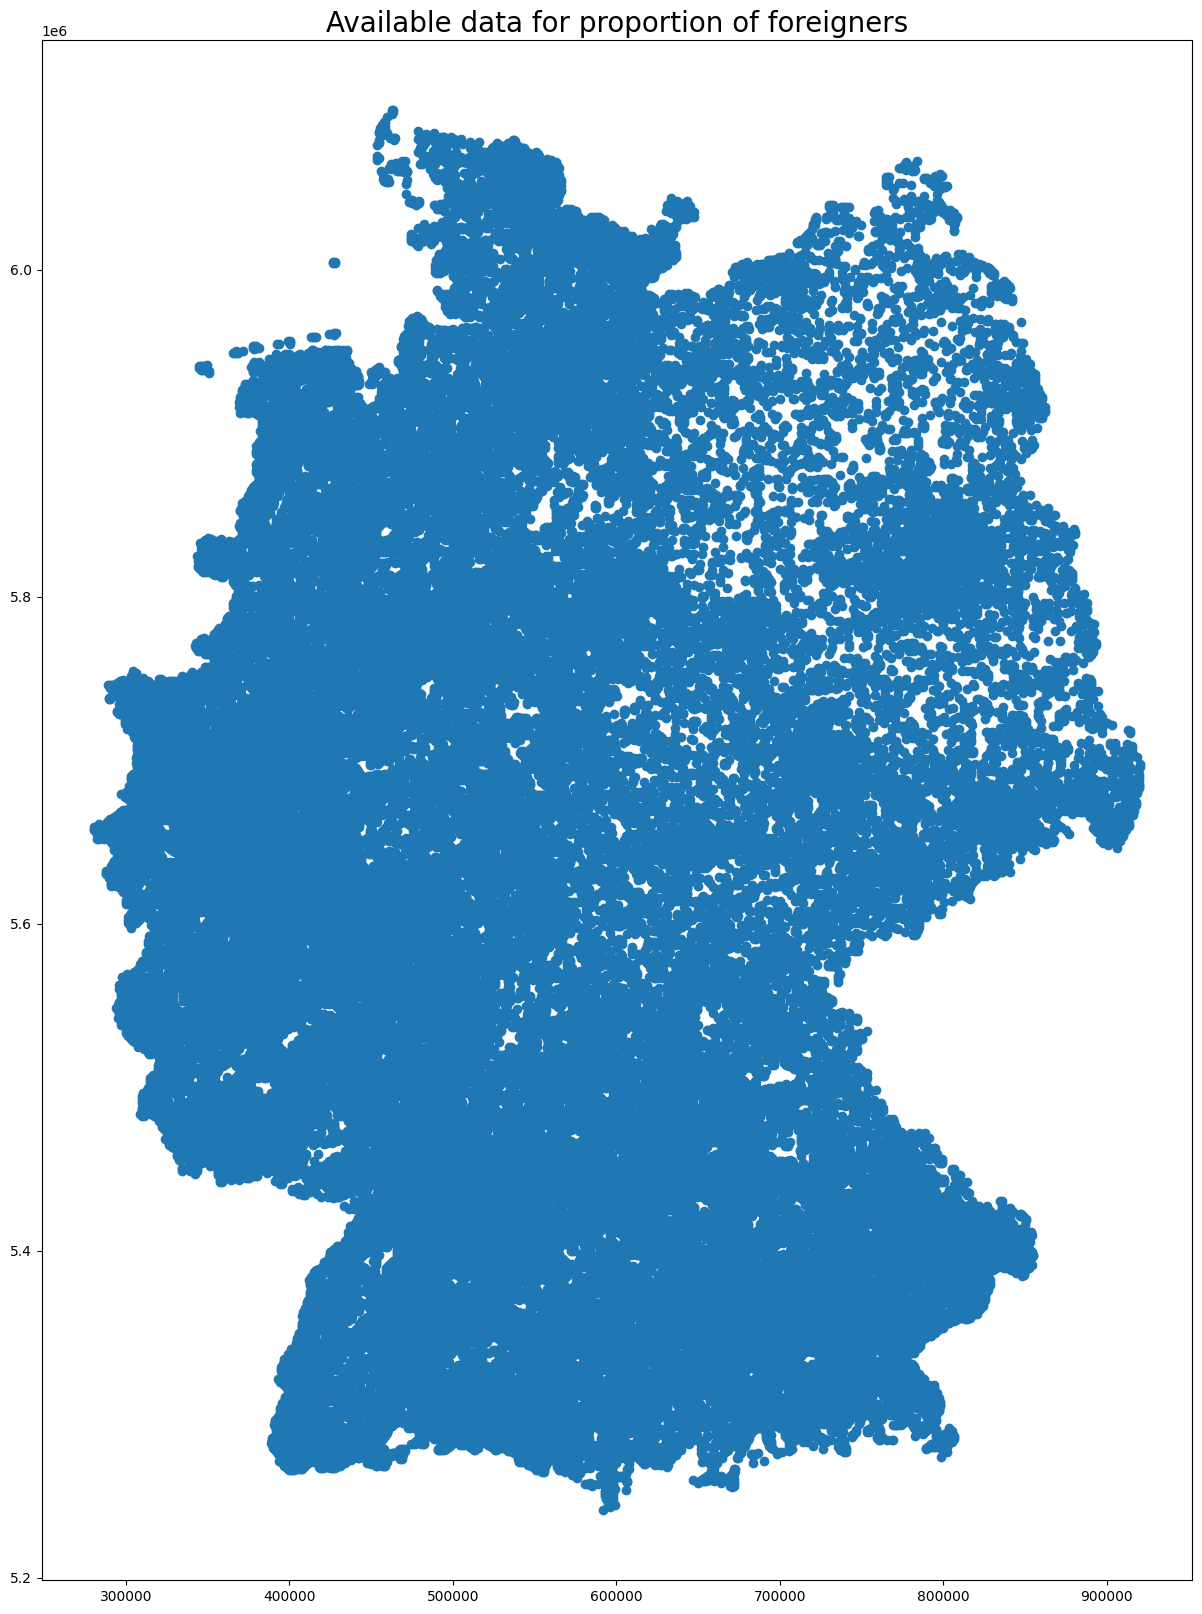

In [ ]:
# Filter rows where the specified column has missing values
missing_rows = prop_foreigners[prop_foreigners["prop_foreigners"].isna()]
not_missing_rows = prop_foreigners[prop_foreigners["prop_foreigners"].notna()]

# Create figure
fig, ax = plt.subplots(figsize=(15, 20)) 

not_missing_rows.plot(ax=ax)
ax.set_title("Available data for proportion of foreigners", fontsize=20) 

plt.show()

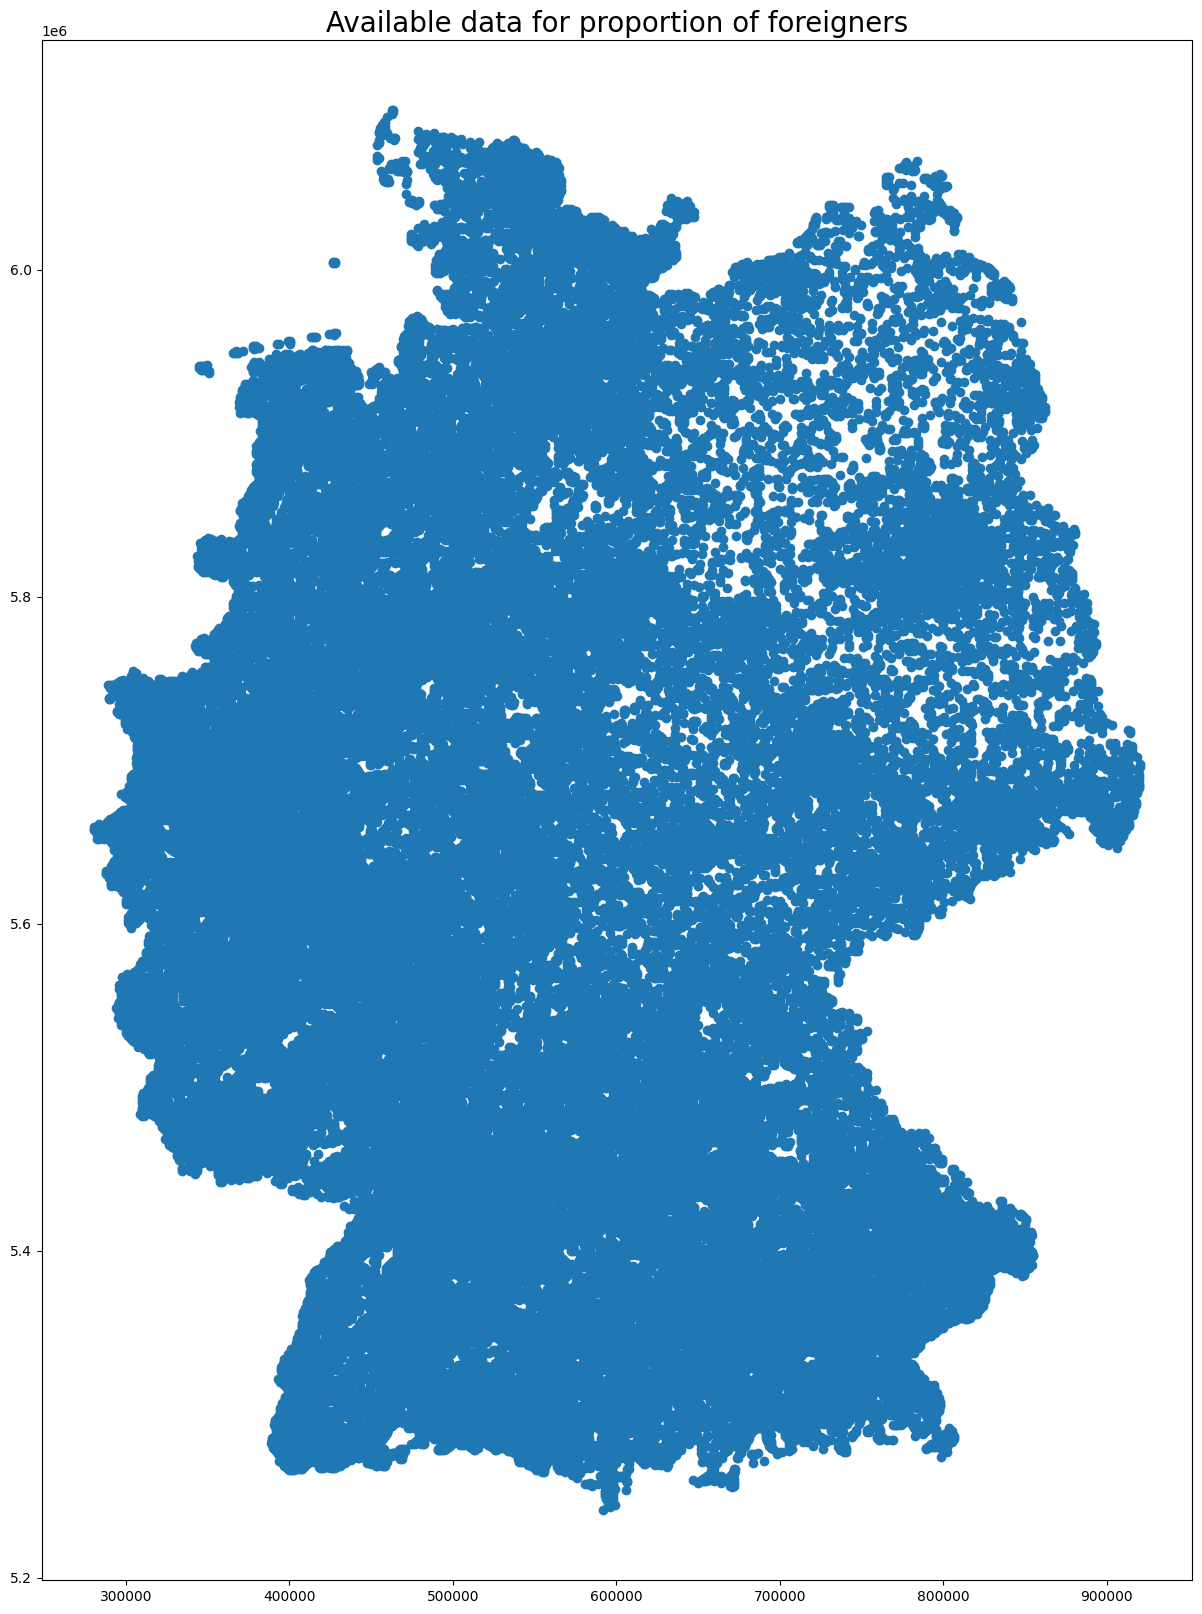

In [146]:
# Filter rows where the specified column has missing values
missing_rows = prop_foreigners[prop_foreigners["prop_foreigners"].isna()]
not_missing_rows = prop_foreigners[prop_foreigners["prop_foreigners"].notna()]

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(15, 20))  # Set figure size

# Plot missing_rows using the specified axis
not_missing_rows.plot(ax=ax)
ax.set_title("Available data for proportion of foreigners", fontsize=20)  # Adjust title and fontsize as needed

# Show the plot
plt.show()

We can see that missing data is a bit more common in the East. Nevertheless there are enough data points on the constituency level to get to aggregate data for all constituencies.
Note also, that the East is less dense in terms of population which might partly explain the pattern.

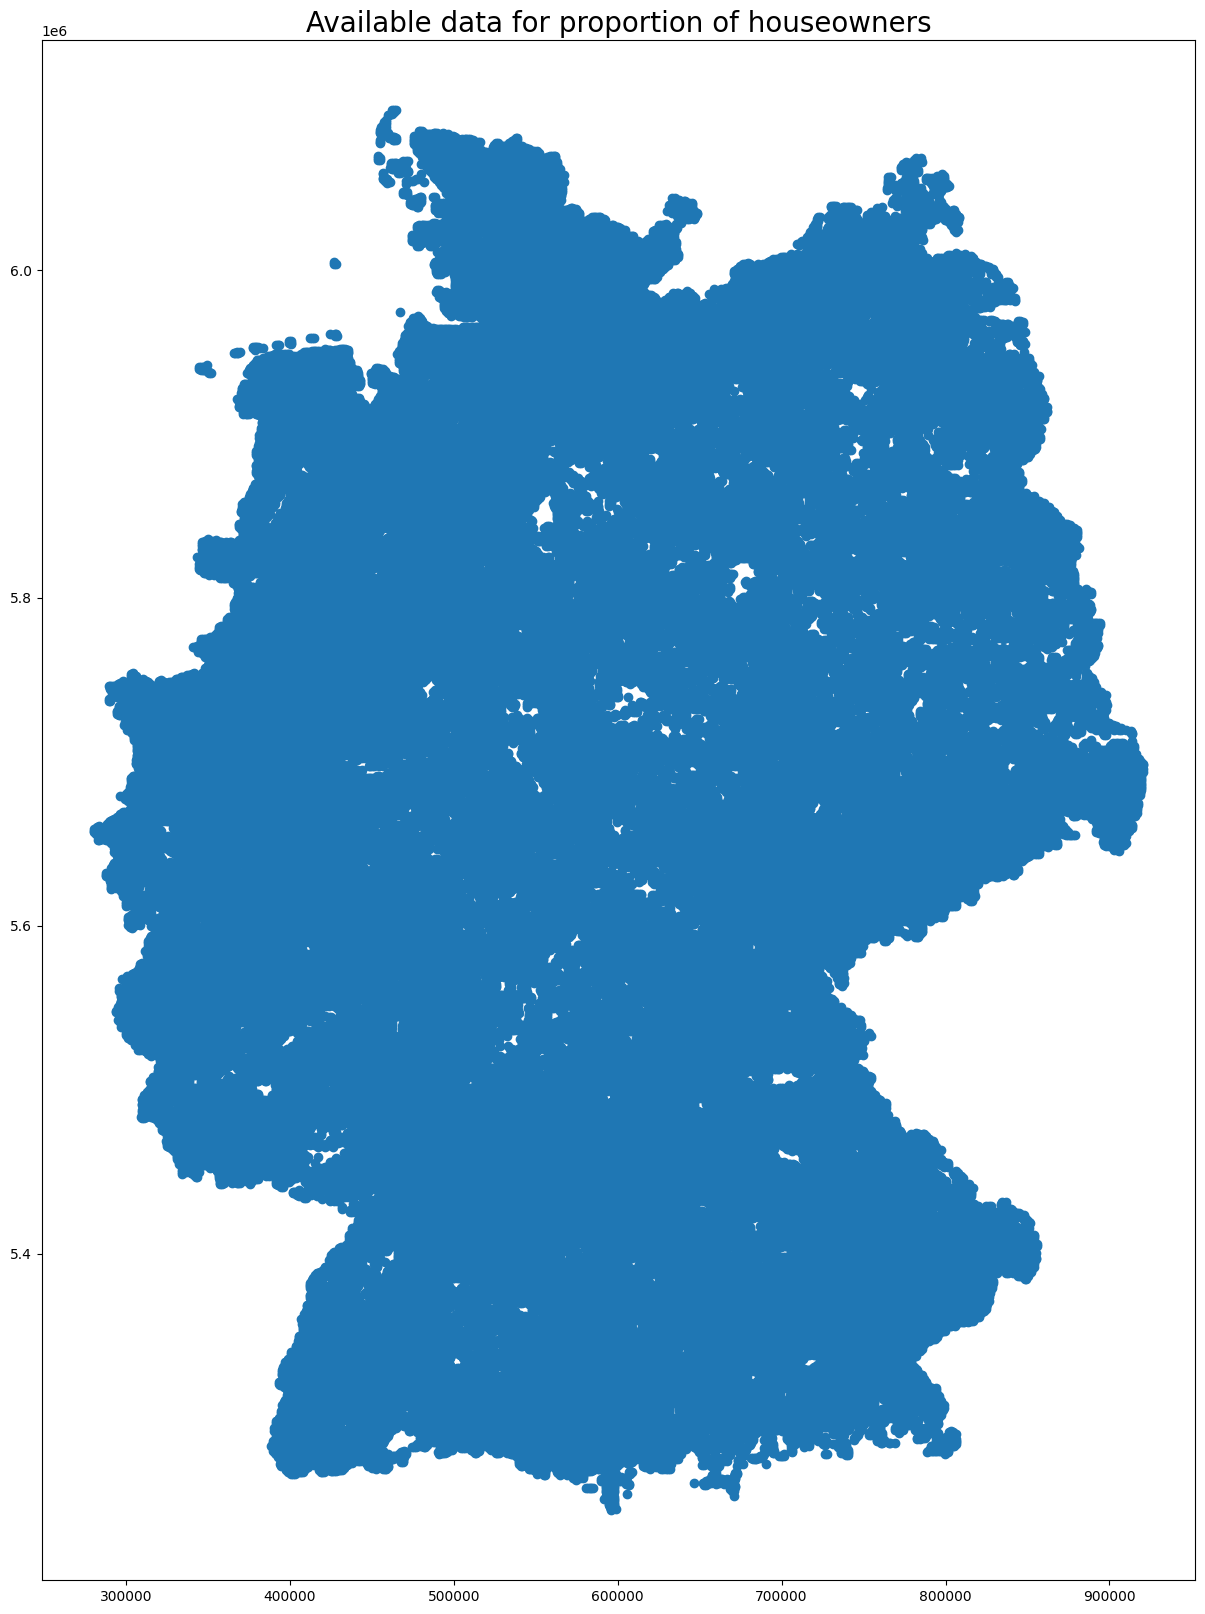

In [147]:
# Filter rows where the specified column has missing values
missing_rows = prop_houseowners[prop_houseowners["prop_houseowners"].isna()]
not_missing_rows = prop_houseowners[prop_houseowners["prop_houseowners"].notna()]

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(15,20))  # Set figure size

# Plot missing_rows using the specified axis
not_missing_rows.plot(ax=ax)
ax.set_title("Available data for proportion of houseowners", fontsize=20)  # Adjust title and fontsize as needed

# Show the plot
plt.show()

--> No worrying pattern of missing data.

## Merge (Preliminary) Election Results with Consituency Shapefiles

In [148]:
# Filter for rows where Gruppenname (party) is 'AfD' and Stimme (vote) is 2 (second vote, determines the seat distribution)
election_results = election_results[(election_results["Gruppenname"] == "AfD") & (election_results["Stimme"] == 2) & (election_results["Gebietsart"] == "Wahlkreis")]

# Select specific columns
selected_columns = ["Gebietsname", "Gruppenname", "Prozent", "VorpProzent"] # area name, party name, percent
election_results = election_results[selected_columns]

# Merge constituencies with election_results
const_results = constituencies.merge(election_results, left_on="WKR_NAME", right_on="Gebietsname", how="left") # wkr_name = name of constituency

# List of eastern states
east_states = ["Brandenburg", "Mecklenburg-Vorpommern", "Sachsen", "Sachsen-Anhalt", "Thüringen"]

# Create the "east" column
const_results["east"] = const_results["LAND_NAME"].isin(east_states).astype(int)

print(const_results.head())

print(" \n Number of missing 2025 election result values: \n", const_results["Prozent"].isna().sum())
print(" \n Number of missing 2021 election result values: \n", const_results["VorpProzent"].isna().sum())

   WKR_NR                           WKR_NAME LAND_NR           LAND_NAME  \
0       1              Flensburg – Schleswig      01  Schleswig-Holstein   
1       2  Nordfriesland – Dithmarschen Nord      01  Schleswig-Holstein   
2       3       Steinburg – Dithmarschen Süd      01  Schleswig-Holstein   
3       4              Rendsburg-Eckernförde      01  Schleswig-Holstein   
4       5                               Kiel      01  Schleswig-Holstein   

                                            geometry  \
0  POLYGON ((9.70877 54.83053, 9.73293 54.82493, ...   
1  MULTIPOLYGON (((8.73594 54.46762, 8.73496 54.4...   
2  MULTIPOLYGON (((8.69258 54.06045, 8.69364 54.0...   
3  POLYGON ((9.97017 54.64701, 9.97222 54.64665, ...   
4  POLYGON ((10.17204 54.43246, 10.17346 54.43039...   

                         Gebietsname Gruppenname    Prozent VorpProzent  east  
0              Flensburg – Schleswig         AfD  15,256022    5,775787     0  
1  Nordfriesland – Dithmarschen Nord         A

<ipython-input-149-03ea0a703b1c>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  afd_cmap = cm.get_cmap("YlOrRd")


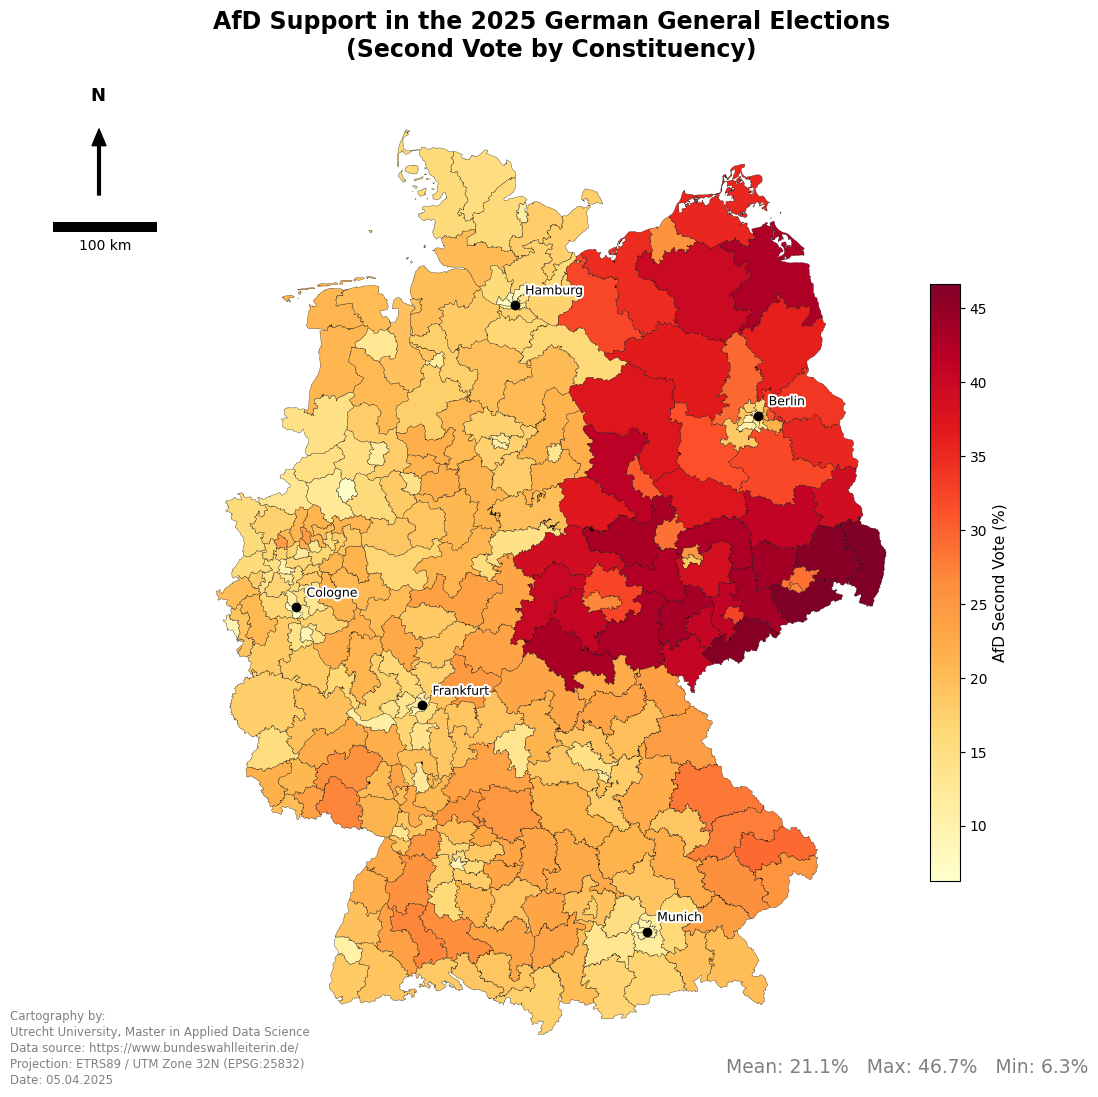

In [149]:
# Convert percentages
const_results["Prozent"] = pd.to_numeric(const_results["Prozent"].str.replace(",", "."), errors="coerce")
const_results["VorpProzent"] = pd.to_numeric(const_results["VorpProzent"].str.replace(",", "."), errors="coerce")

# Mark East Germany
east_states = ["Brandenburg", "Mecklenburg-Vorpommern", "Sachsen", "Sachsen-Anhalt", "Thüringen"]
const_results["east"] = const_results["LAND_NAME"].isin(east_states).astype(int)

# Set CRS
const_results = const_results.to_crs(epsg=25832)

# Bundesländer borders
try:
    states = gpd.read_file("/content/german_states.shp")
    states = states.to_crs(epsg=25832)
except:
    states = None

# Color map
afd_cmap = cm.get_cmap("YlOrRd")

# Setup plot
fig, ax = plt.subplots(figsize=(11, 11))

# Plot data
const_results.plot(
    column="Prozent",
    cmap=afd_cmap,
    linewidth=0.2,
    ax=ax,
    edgecolor='black',
    legend=False
)

if states is not None:
    states.boundary.plot(ax=ax, linewidth=0.8, color='black')

# Colorbar
norm = mpl.colors.Normalize(
    vmin=const_results["Prozent"].min(),
    vmax=const_results["Prozent"].max()
)
sm = plt.cm.ScalarMappable(cmap=afd_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.01)
cbar.set_label("AfD Second Vote (%)", fontsize=11)

# Title
plt.title("AfD Support in the 2025 German General Elections\n(Second Vote by Constituency)",
          fontsize=17, fontweight='bold', pad=20)

# Top 5 biggest cities
city_df = pd.DataFrame({
    "city": ["Berlin", "Munich", "Frankfurt", "Hamburg", "Cologne"],
    "lon": [13.4050, 11.5820, 8.6821, 9.9937, 6.9603],
    "lat": [52.5200, 48.1351, 50.1109, 53.5511, 50.9375]
})

city_gdf = gpd.GeoDataFrame(
    city_df,
    geometry=gpd.points_from_xy(city_df.lon, city_df.lat),
    crs="EPSG:4326"
).to_crs(epsg=25832)

for _, row in city_gdf.iterrows():
    ax.plot(row.geometry.x, row.geometry.y, 'o', markersize=6, color='black', zorder=3)
    ax.text(
    row.geometry.x + 10000,
    row.geometry.y + 10000,
    row["city"],
    fontsize=9,
    color='black',
    zorder=3,
    path_effects=[withStroke(linewidth=3, foreground='white')]
    )

# North arrow
arrow_x = 0.09
arrow_y = 0.90
plt.figtext(arrow_x, arrow_y, "N", fontsize=13, fontweight='bold', ha='center', va='bottom')
ax.annotate("",
            xy=(arrow_x, arrow_y - 0.02),
            xytext=(arrow_x, arrow_y - 0.08),
            xycoords='figure fraction',
            textcoords='figure fraction',
            arrowprops=dict(facecolor='black', edgecolor='black', width=2, headwidth=10))

# Scale bar
scalebar = ScaleBar(
    1, units="m", dimension="si-length", length_fraction=0.15,
    scale_loc="bottom", box_alpha=0, pad=0.4
)
arrow_x = 0.15
arrow_y = 0.88
transform = blended_transform_factory(fig.transFigure, fig.transFigure)
scalebar.set_transform(transform)
scalebar.set_bbox_to_anchor((arrow_x, arrow_y - 0.08))
scalebar.set_bbox_transform(fig.transFigure)
ax.add_artist(scalebar)
# ax.add_artist(scalebar)

# Info block
source_text = (
    "Cartography by:\n"
    "Utrecht University, Master in Applied Data Science\n"
    "Data source: https://www.bundeswahlleiterin.de/\n"
    "Projection: ETRS89 / UTM Zone 32N (EPSG:25832)\n"
    "Date: 05.04.2025"
)
plt.figtext(0.01, 0.01, source_text, fontsize=8.5, ha='left', color='gray', linespacing=1.3)

# Summary statistics
mean_support = const_results['Prozent'].mean()
max_support = const_results['Prozent'].max()
min_support = const_results['Prozent'].min()
stats_text = f"Mean: {mean_support:.1f}%   Max: {max_support:.1f}%   Min: {min_support:.1f}%"
plt.figtext(0.99, 0.02, stats_text, fontsize=13.5, ha='right', color='gray')

# Final layout
ax.axis('off')
plt.tight_layout()
plt.savefig("afd_vote_map.png", dpi=300, bbox_inches="tight")
plt.show()

## Merge Consituency / Election Data with Zensus Data

Zensus data is stored as centriods of raster cells, thus it is point data.
Data is aggregated as mean or sum to the level of constituency.

<Axes: >

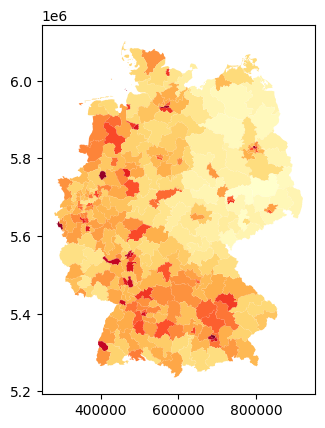

In [128]:
def compute_attribute_per_polygon(points_gdf, polygons_gdf, attribute, result_column_name, aggregation='mean'):
    # Perform spatial join
    joined = gpd.sjoin(points_gdf, polygons_gdf, how="inner", predicate="within")

    # Apply the chosen aggregation (mean or sum)
    if aggregation == 'mean':
        agg_values = joined.groupby("index_right")[attribute].mean().reset_index()
    elif aggregation == 'sum':
        agg_values = joined.groupby("index_right")[attribute].sum().reset_index()
    else:
        raise ValueError("Aggregation must be 'mean' or 'sum'")

    # Merge the aggregated values back into the polygons GeoDataFrame
    polygons_gdf = polygons_gdf.merge(agg_values, left_index=True, right_on="index_right", how="left")
    polygons_gdf.set_index("index_right", inplace=True)
    polygons_gdf = polygons_gdf.loc[:, ~polygons_gdf.columns.duplicated()]

    # Rename and convert the result column to float
    polygons_gdf.rename(columns={attribute: result_column_name}, inplace=True)
    polygons_gdf[result_column_name] = pd.to_numeric(polygons_gdf[result_column_name]).astype(float)

    return polygons_gdf

df_election_results_census = compute_attribute_per_polygon(prop_foreigners, const_results, "prop_foreigners", "prop_foreigners_mean", aggregation='mean')
df_election_results_census = compute_attribute_per_polygon(avg_age, df_election_results_census, "avg_age", "avg_age_mean", aggregation='mean')
df_election_results_census = compute_attribute_per_polygon(prop_houseowners, df_election_results_census, "prop_houseowners", "prop_houseowners_mean", aggregation='mean')
df_election_results_census = compute_attribute_per_polygon(avg_rent_cold, df_election_results_census, "avg_rent_SQM", "avg_rent_SQM_mean", aggregation='mean')
df_election_results_census = compute_attribute_per_polygon(avg_livingspace, df_election_results_census, "avg_livingspace", "avg_livingspace_mean", aggregation='mean')
df_election_results_census = compute_attribute_per_polygon(population_count, df_election_results_census, "population_count", "population_count_sum", aggregation='sum')

df_election_results_census = compute_attribute_per_polygon(age_5cats, df_election_results_census, "below18", "below18_sum", aggregation='sum')
df_election_results_census = compute_attribute_per_polygon(age_5cats, df_election_results_census, "a18-29", "a18-29_sum", aggregation='sum')
df_election_results_census = compute_attribute_per_polygon(age_5cats, df_election_results_census, "a30-49", "a30-49_sum", aggregation='sum')
df_election_results_census = compute_attribute_per_polygon(age_5cats, df_election_results_census, "a50-64", "a50-64_sum", aggregation='sum')
df_election_results_census = compute_attribute_per_polygon(age_5cats, df_election_results_census, "above64", "above64_sum", aggregation='sum')

# Plot
df_election_results_census.plot(
    column="a18-29_sum",
    cmap=afd_cmap
)

## Merge Regionalatlas Data (Vector) with Constituencies

Areas do not match as constituencies are not the same as administrative units, so weighted areal interpolation is used to merge and account for varying proportions of spatial overlap.

           WKR_NR                           WKR_NAME LAND_NR  \
target_id                                                      
0               1              Flensburg – Schleswig      01   
1               2  Nordfriesland – Dithmarschen Nord      01   
2               3       Steinburg – Dithmarschen Süd      01   
3               4              Rendsburg-Eckernförde      01   
4               5                               Kiel      01   
...           ...                                ...     ...   
294           295           Zollernalb – Sigmaringen      08   
295           296                        Saarbrücken      10   
296           297                          Saarlouis      10   
297           298                         St. Wendel      10   
298           299                            Homburg      10   

                    LAND_NAME  \
target_id                       
0          Schleswig-Holstein   
1          Schleswig-Holstein   
2          Schleswig-Holstein   
3 

<Axes: >

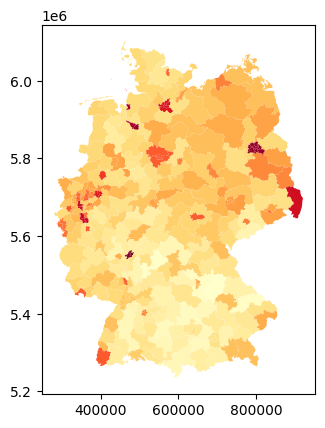

In [129]:
def interpolate_weighted_attribute(source_gdf, target_gdf, attribute_column, result_column_name):
    """
    Performs an area-weighted interpolation of an attribute from one polygon layer (source_gdf)
    to another (target_gdf).

    Parameters:
        source_gdf (GeoDataFrame): Source polygons containing the attribute to interpolate.
        target_gdf (GeoDataFrame): Target polygons where interpolated values should be stored.
        attribute_column (str): Column name in source_gdf that contains the attribute.
        result_column_name (str): Name of the new column in target_gdf with interpolated values.

    Returns:
        GeoDataFrame: target_gdf with the new interpolated column.
    """
    # If "target_id" is already in the columns, drop it to avoid ambiguity
    if "target_id" in target_gdf.columns:
        target_gdf = target_gdf.drop(columns=["target_id"])

    # Store the original index as a column before overlay
    target_gdf = target_gdf.copy()

    # Ensure "target_id" is not an index before creating it
    if target_gdf.index.name == "target_id":
        target_gdf = target_gdf.reset_index()

    target_gdf["target_id"] = target_gdf.index  # Explicitly store index as column

    # Perform intersection to find overlapping areas
    intersection = gpd.overlay(source_gdf, target_gdf, how='intersection')

    # Ensure 'target_id' is present after overlay
    if "target_id" not in intersection.columns:
        raise KeyError(f"'target_id' is missing in the intersection result. Columns available: {intersection.columns.tolist()}")

    # Calculate the area of each intersected part
    intersection["intersection_area"] = intersection.geometry.area

    # Calculate the proportion of each source polygon that falls into each target polygon
    intersection["area_proportion"] = intersection["intersection_area"] / intersection.groupby("target_id")["intersection_area"].transform("sum")

    # Compute the weighted attribute value
    intersection["weighted_value"] = intersection[attribute_column] * intersection["area_proportion"]

    # Aggregate to get final interpolated attribute value for each target polygon
    interpolated_values = intersection.groupby("target_id")["weighted_value"].sum().reset_index()

    # Ensure "target_id" is only an index or a column (not both) before merging
    if "target_id" in target_gdf.index.names:
        target_gdf = target_gdf.reset_index()

    # Merge results back into target_gdf
    target_gdf = target_gdf.merge(interpolated_values, on="target_id", how="left")

    # Restore original index
    target_gdf = target_gdf.set_index("target_id")

    # Ensure unique columns and rename
    target_gdf = target_gdf.loc[:, ~target_gdf.columns.duplicated()]
    target_gdf.rename(columns={"weighted_value": result_column_name}, inplace=True)

    return target_gdf


df_full = interpolate_weighted_attribute(source_gdf=proportion_agriculture, target_gdf=df_election_results_census, attribute_column="proportion_agriculture", result_column_name="proportion_agriculture_interpolated")
df_full = interpolate_weighted_attribute(source_gdf=disposable_income, target_gdf=df_full, attribute_column="disposable_income", result_column_name="disposable_income_interpolated")
df_full = interpolate_weighted_attribute(source_gdf=proportion_residential_transport, target_gdf=df_full, attribute_column="proportion_residential_transport", result_column_name="proportion_residential_transport_interpolated")
df_full = interpolate_weighted_attribute(source_gdf=unemployment_rate, target_gdf=df_full, attribute_column="unemployment_rate", result_column_name="unemployment_rate_interpolated")
df_full = interpolate_weighted_attribute(source_gdf=unemployment_rate, target_gdf=df_full, attribute_column="crime_count_per100.000", result_column_name="crime_count_per100.000_interpolated")

print(df_full)
df_full.plot(
    column="crime_count_per100.000_interpolated",
    cmap=afd_cmap
)

# Calculate population density and proportion of young and elderly

In [130]:
# Calculate area in square meters
df_full["area_sqm"] = df_full.geometry.area

# Compute population density (people per square kilometer)
df_full["population_density_km2"] = (df_full["population_count_sum"] / df_full["area_sqm"] ) * 1e6  # Convert from per m² to per km²


# Calculate proportion of young people (18-29)
# Compute proportion of 18-29 years old
df_full["prop_18-29"] = df_full["a18-29_sum"] / df_full["population_count_sum"]

# Calculate proportion of elderly (>=65)
df_full["prop_above64"] = df_full["above64_sum"] / df_full["population_count_sum"]

<ipython-input-133-d64f82977e38>:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(row.geometry.centroid, anschlags_gdf.geometry.unary_union)[1]


<Axes: >

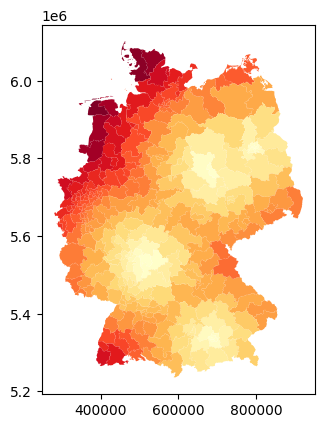

In [133]:
# list of constituencies in which there was a terror attack within two months of the elections
anschlags_wahlkreise = [69, 219, 74, 246]  # Magdeburg, München-West/Mitte, Berlin-Mitte, Aschaffenburg

df_full["attack"] = df_full["WKR_NR"].apply(lambda x: 1 if x in anschlags_wahlkreise else 0)

from shapely.ops import nearest_points

anschlags_gdf = df_full[df_full["attack"] == 1].copy()

# calculate distance to next constituency with terror attack
def get_nearest_distance(row, anschlags_gdf):
    if row["attack"] == 1:
        return 0  # 0 for the constituency with the terror attack

    nearest_geom = nearest_points(row.geometry.centroid, anschlags_gdf.geometry.unary_union)[1]
    return row.geometry.centroid.distance(nearest_geom) / 1000  # Umwandlung in Kilometer

df_full["distance_terror"] = df_full.apply(lambda row: get_nearest_distance(row, anschlags_gdf), axis=1)

# plot result
df_full.plot(
    column="distance_terror",
    cmap=afd_cmap
)


## Safe Dataset (Write to file)

In [ ]:
#output_path = "Data/df_full_post_data_collection.gpkg"
#df_full.to_file(output_path, driver="GPKG")

#df_full_post_data_collection = gpd.read_file(output_path)
#print(df_full_post_data_collection.head())

# (S)EDA

In [ ]:
print(df_full_post_data_collection.columns)
df_short = df_full_post_data_collection[['percentAfD25', 'percentAfD21', 'east', 'WKR_NAME', 'LAND_NAME', 'geometry', 'prop_foreigners_mean', 'avg_age_mean', 'prop_houseowners_mean', 'avg_rent_SQM_mean',
       'avg_livingspace_mean', 'proportion_agriculture_interpolated', 'disposable_income_interpolated', 'proportion_residential_transport_interpolated', 'unemployment_rate_interpolated',
       'area_sqm', 'population_density_km2', 'prop_18-29', 'prop_above64', 'crime_count_per100.000_interpolated', 'distance_terror']]
print(df_short.columns)

numeric_analysis_vars =  df_short[['percentAfD25', 'percentAfD21', 'east', 'prop_foreigners_mean', 'avg_age_mean', 'prop_houseowners_mean', 'avg_rent_SQM_mean', 'avg_livingspace_mean', 'proportion_agriculture_interpolated', 'disposable_income_interpolated',
       'proportion_residential_transport_interpolated', 'unemployment_rate_interpolated', 'area_sqm', 'population_density_km2', 'prop_18-29', 'prop_above64', 'crime_count_per100.000_interpolated', 'distance_terror']]

Index(['WKR_NR', 'WKR_NAME', 'LAND_NR', 'LAND_NAME', 'geometry', 'Gebietsname',
       'Gruppenname', 'Prozent', 'VorpProzent', 'east', 'percentAfD25',
       'percentAfD21', 'prop_foreigners_mean', 'avg_age_mean',
       'prop_houseowners_mean', 'avg_rent_SQM_mean', 'avg_livingspace_mean',
       'population_count_sum', 'below18_sum', 'a18-29_sum', 'a30-49_sum',
       'a50-64_sum', 'above64_sum', 'proportion_agriculture_interpolated',
       'disposable_income_interpolated',
       'proportion_residential_transport_interpolated',
       'unemployment_rate_interpolated', 'crime_count_per100.000_interpolated',
       'area_sqm', 'population_density_km2', 'prop_18-29', 'prop_above64',
       'attack', 'distance_terror'],
      dtype='object')
Index(['percentAfD25', 'percentAfD21', 'east', 'WKR_NAME', 'LAND_NAME',
       'geometry', 'prop_foreigners_mean', 'avg_age_mean',
       'prop_houseowners_mean', 'avg_rent_SQM_mean', 'avg_livingspace_mean',
       'proportion_agriculture_interpola

### Check Outlier

There are no misisng values, since they were compensated by the interpolation above.

In [135]:
def outlier_analysis(df, column_name):
    """
    Analyzes a specified column of a DataFrame.
    - Prints the number of missing values.
    - Displays a histogram and boxplot (handles missing values).
    - Counts the number of outliers using 1.5 standard deviations from the median.

    :param df: Pandas DataFrame
    :param column_name: Column name as a string
    """

    # Print missing values
    missing_values = df[column_name].isna().sum()
    print(f"\nNumber of missing values in '{column_name}': {missing_values}")

    # Remove missing values for plotting
    clean_data = df[column_name].dropna()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Histogram
    axes[0].hist(clean_data, bins=30, edgecolor="black")
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Histogram")

    # Boxplot (Vertical) - Handles missing values
    axes[1].boxplot(clean_data)
    axes[1].set_ylabel(column_name)
    axes[1].set_title("Boxplot")

    plt.tight_layout()  # Adjust spacing
    plt.show()

    # Count outliers (ignoring missing values)
    mean = clean_data.mean()
    std_dev = clean_data.std()
    upper_threshold = mean + 2 * std_dev
    lower_threshold = mean - 2 * std_dev
    outlier_count = ((clean_data > upper_threshold) | (clean_data < lower_threshold)).sum()

    print(f"Number of rows with outliers in '{column_name}': {outlier_count}")

Variable: 
 percentAfD25

Number of missing values in 'percentAfD25': 0


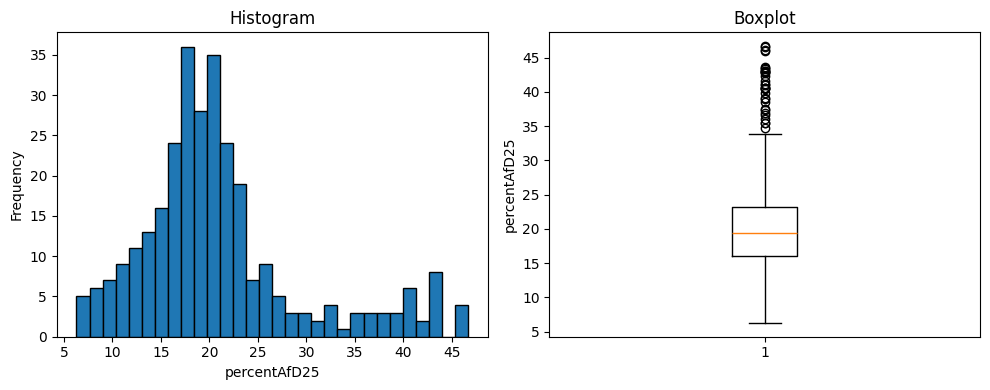

Number of rows with outliers in 'percentAfD25': 24


Variable: 
 percentAfD21

Number of missing values in 'percentAfD21': 0


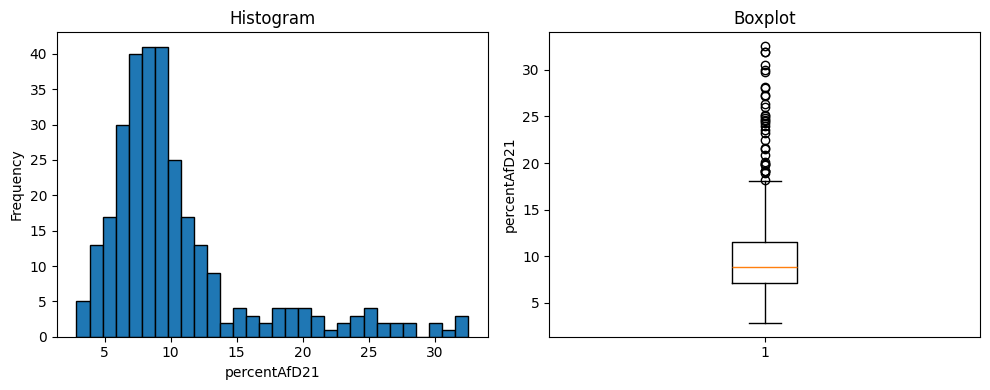

Number of rows with outliers in 'percentAfD21': 22


Variable: 
 east

Number of missing values in 'east': 0


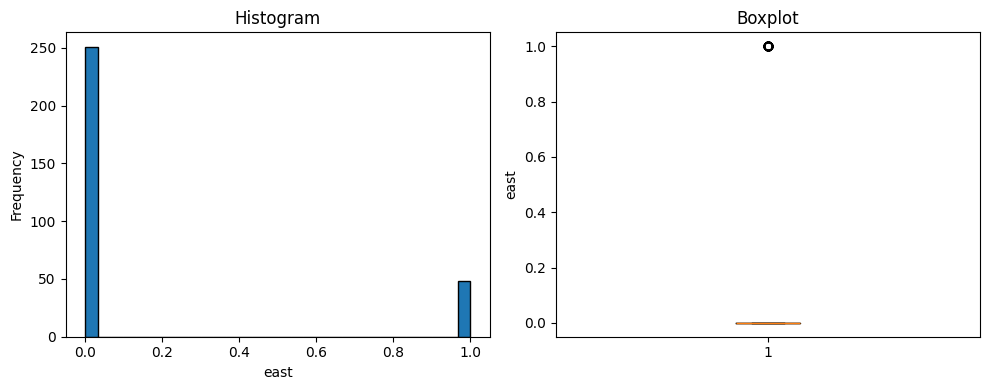

Number of rows with outliers in 'east': 48


Variable: 
 prop_foreigners_mean

Number of missing values in 'prop_foreigners_mean': 0


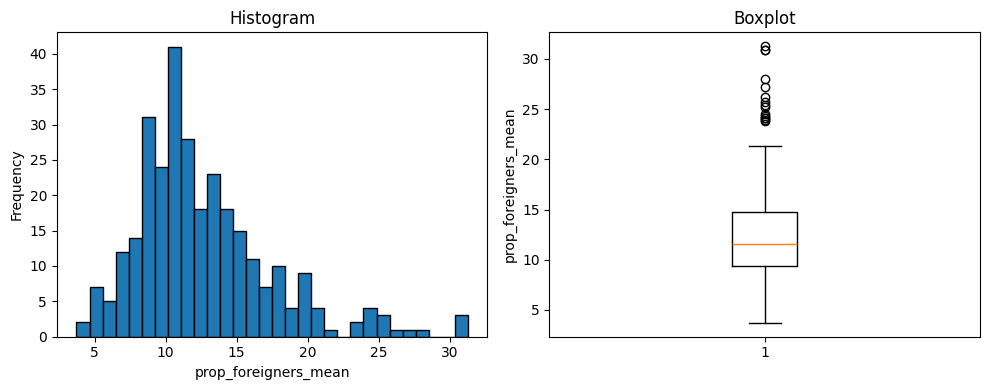

Number of rows with outliers in 'prop_foreigners_mean': 15


Variable: 
 avg_age_mean

Number of missing values in 'avg_age_mean': 0


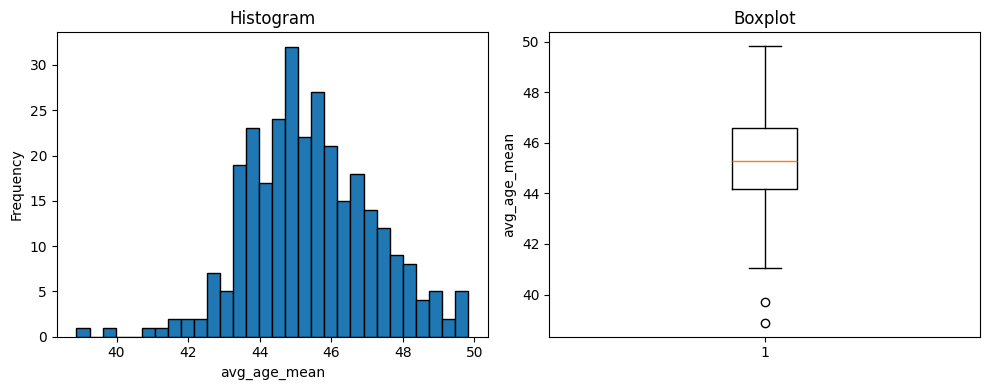

Number of rows with outliers in 'avg_age_mean': 16


Variable: 
 prop_houseowners_mean

Number of missing values in 'prop_houseowners_mean': 0


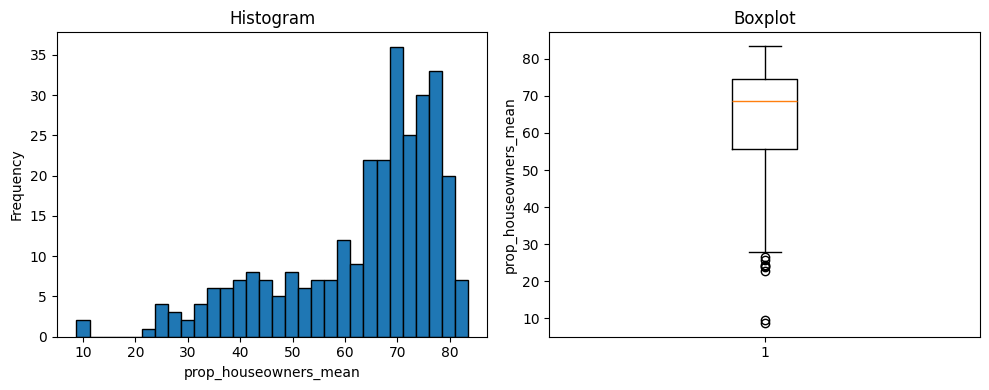

Number of rows with outliers in 'prop_houseowners_mean': 15


Variable: 
 avg_rent_SQM_mean

Number of missing values in 'avg_rent_SQM_mean': 0


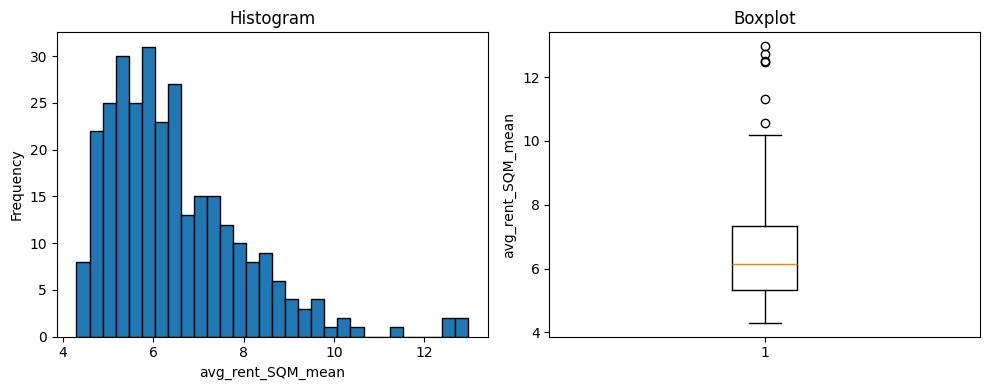

Number of rows with outliers in 'avg_rent_SQM_mean': 13


Variable: 
 avg_livingspace_mean

Number of missing values in 'avg_livingspace_mean': 0


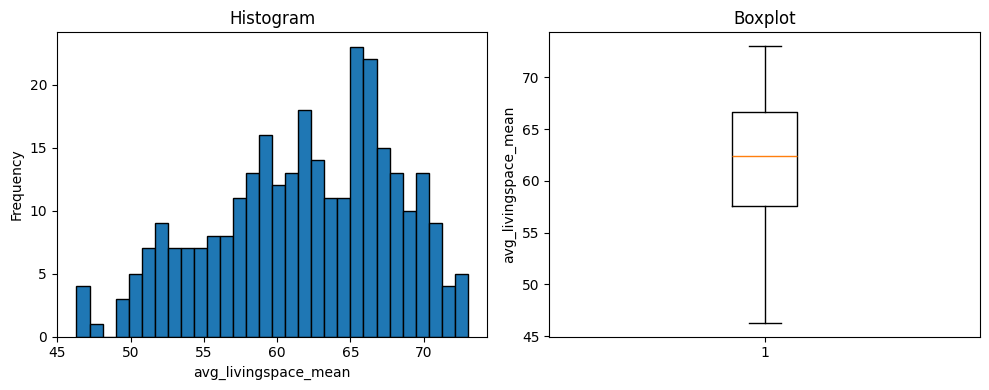

Number of rows with outliers in 'avg_livingspace_mean': 7


Variable: 
 proportion_agriculture_interpolated

Number of missing values in 'proportion_agriculture_interpolated': 0


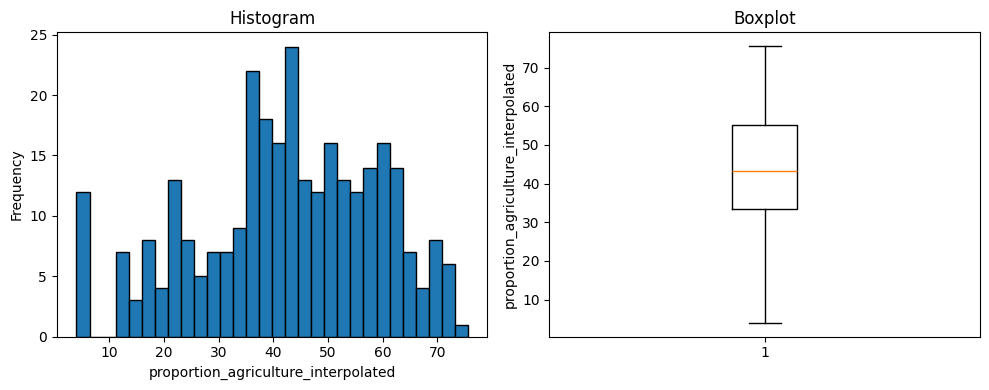

Number of rows with outliers in 'proportion_agriculture_interpolated': 12


Variable: 
 disposable_income_interpolated

Number of missing values in 'disposable_income_interpolated': 0


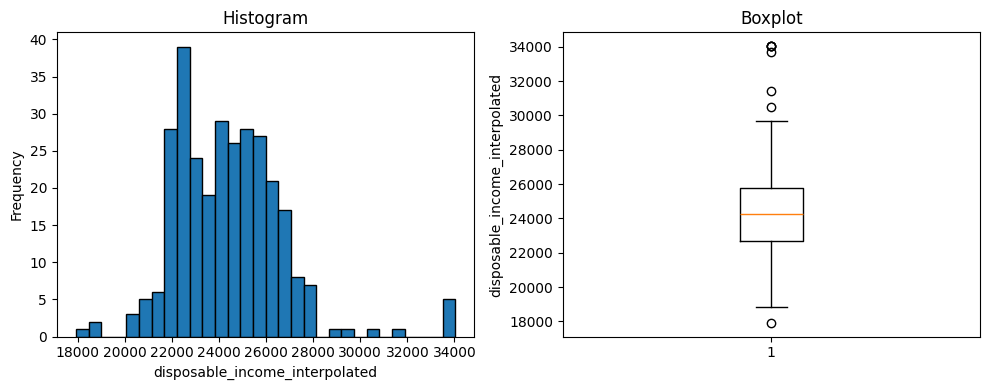

Number of rows with outliers in 'disposable_income_interpolated': 12


Variable: 
 proportion_residential_transport_interpolated

Number of missing values in 'proportion_residential_transport_interpolated': 0


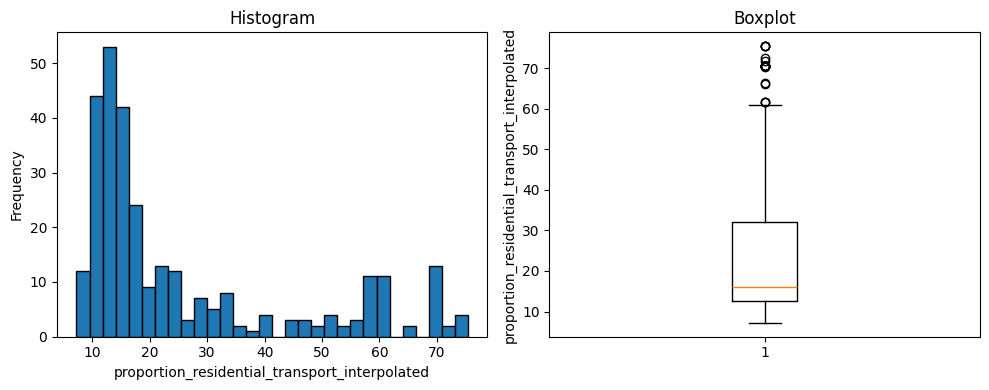

Number of rows with outliers in 'proportion_residential_transport_interpolated': 21


Variable: 
 unemployment_rate_interpolated

Number of missing values in 'unemployment_rate_interpolated': 0


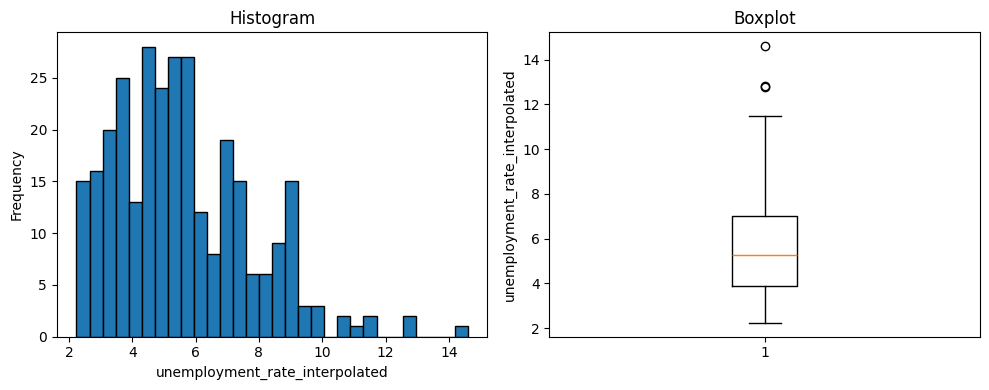

Number of rows with outliers in 'unemployment_rate_interpolated': 9


Variable: 
 area_sqm

Number of missing values in 'area_sqm': 0


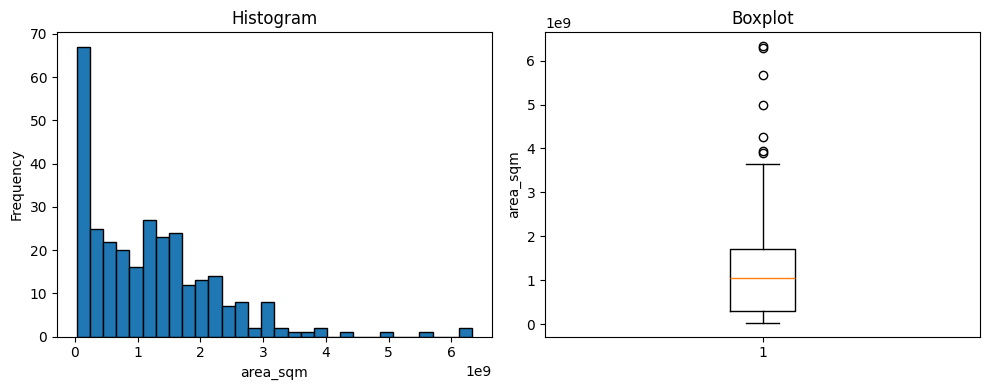

Number of rows with outliers in 'area_sqm': 9


Variable: 
 population_density_km2

Number of missing values in 'population_density_km2': 0


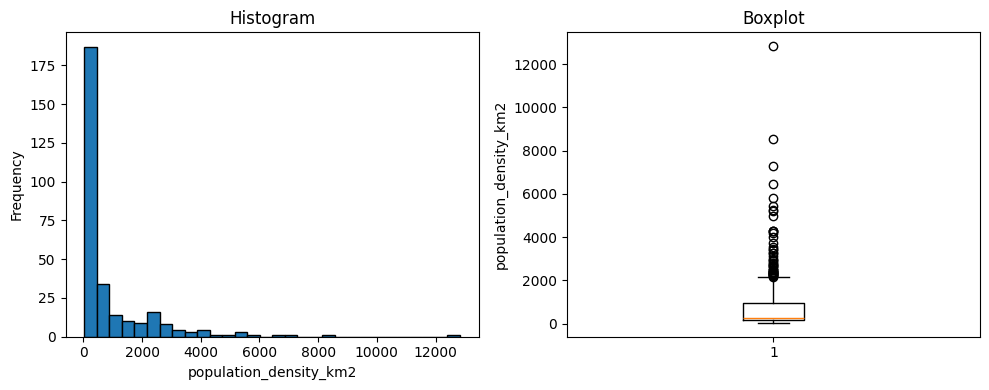

Number of rows with outliers in 'population_density_km2': 14


Variable: 
 prop_18-29

Number of missing values in 'prop_18-29': 0


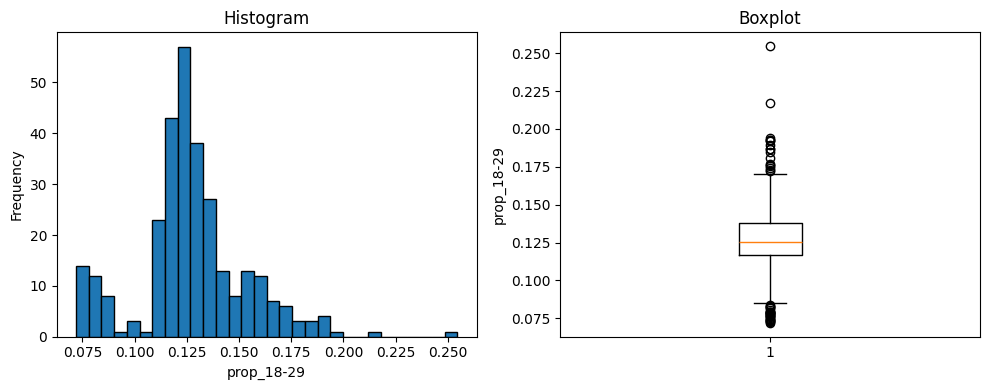

Number of rows with outliers in 'prop_18-29': 17


Variable: 
 prop_above64

Number of missing values in 'prop_above64': 0


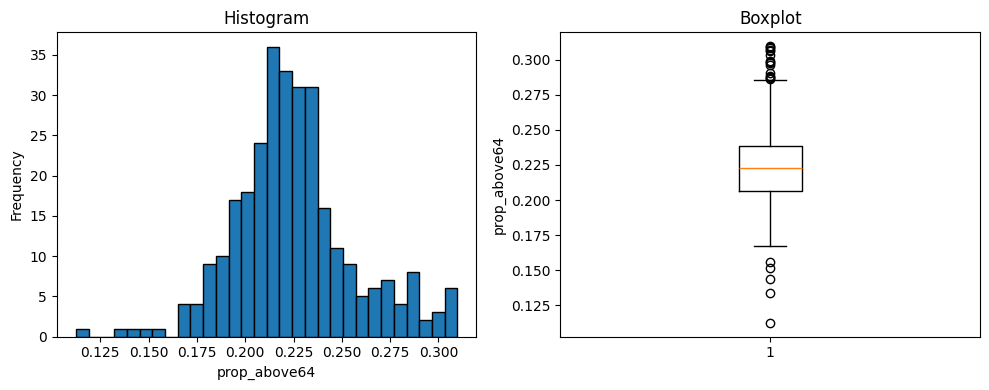

Number of rows with outliers in 'prop_above64': 19


Variable: 
 crime_count_per100.000_interpolated

Number of missing values in 'crime_count_per100.000_interpolated': 0


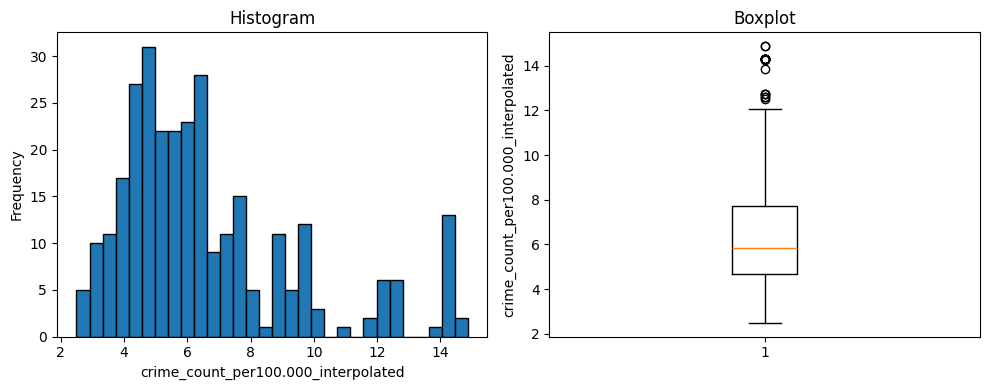

Number of rows with outliers in 'crime_count_per100.000_interpolated': 22


Variable: 
 distance_terror

Number of missing values in 'distance_terror': 0


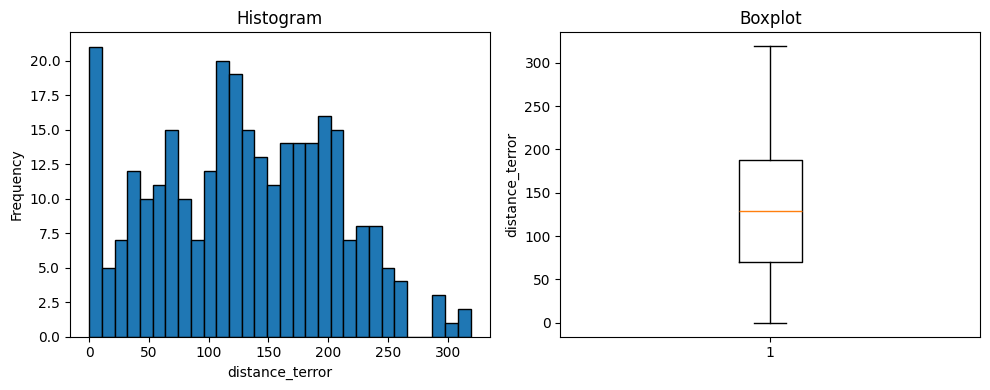

Number of rows with outliers in 'distance_terror': 6




In [136]:
for column in numeric_analysis_vars:
    print("Variable: \n", column)
    outlier_analysis(df_full, column)
    print("\n")
    #cap_outliers(df_full, column)

## EDA (Pairplots and Choropleth Maps)

In [ ]:
# Select only numeric columns if not specified
columns = df_short.select_dtypes(include=["number"]).columns.tolist()

# Create the pairplot with histograms on the diagonal and regression lines
pairplot = sns.pairplot(
    df_short[columns],
    diag_kind="hist",
    kind="reg",
    plot_kws={"scatter_kws": {"alpha": 0.4, "edgecolor": "k"}}
)

    # Adjust title position
plt.suptitle("Pairplot", y=1.02)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

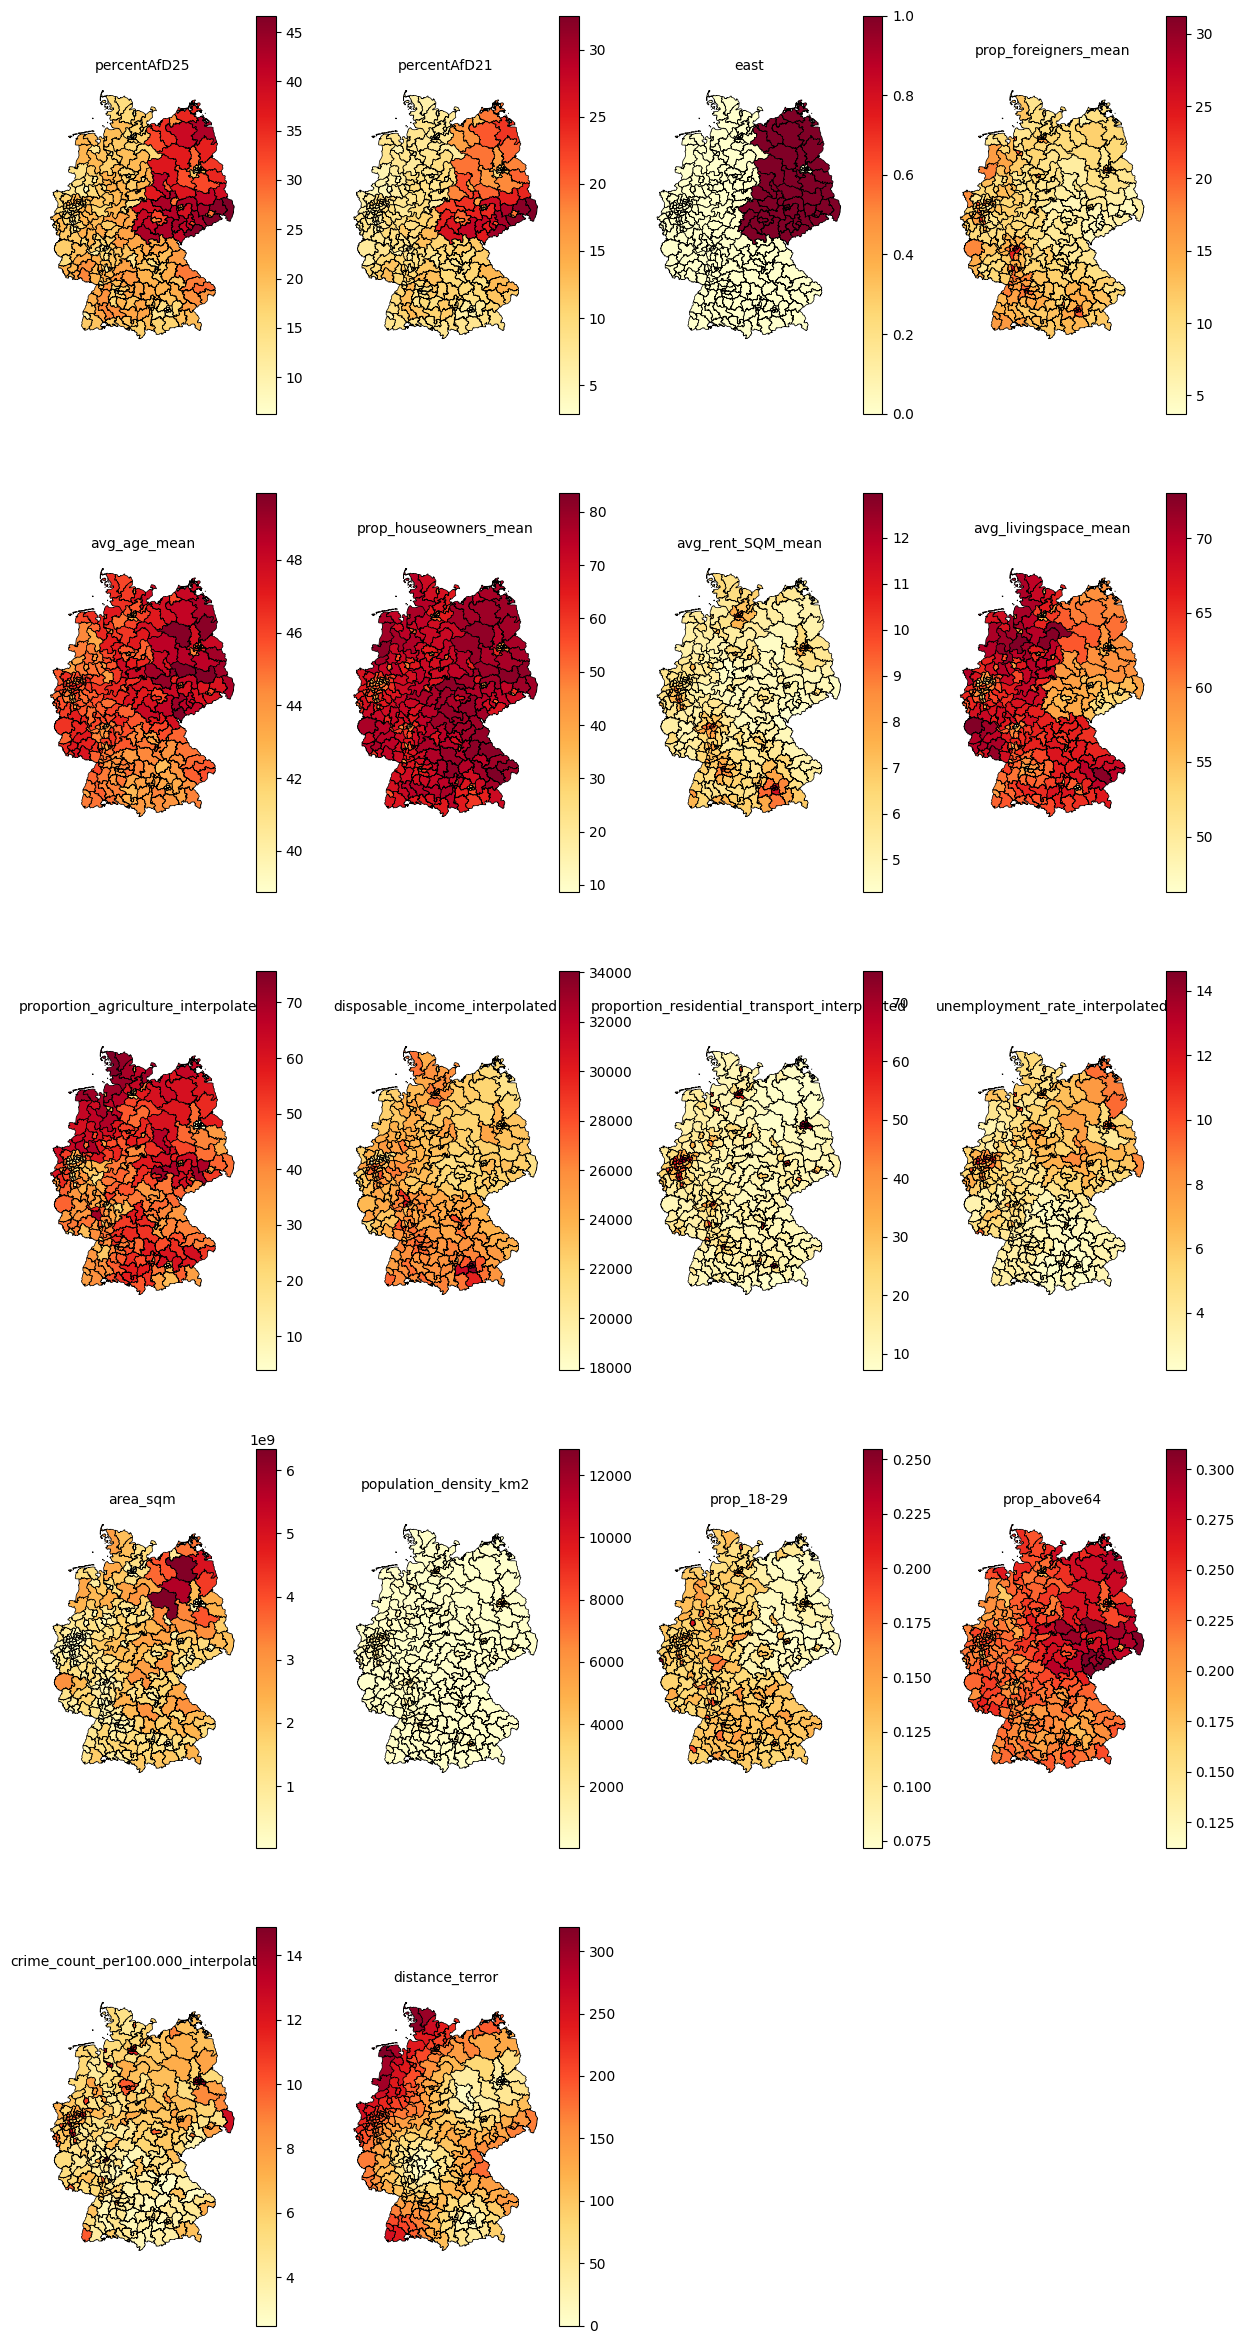

In [139]:
# Select only numeric columns, excluding geometry
columns = df_short.select_dtypes(include=["number"]).columns.tolist()
columns = [col for col in columns if col != "geometry"]

# Set number of columns per row
columns_per_row = 4
num_columns = len(columns)
num_rows = math.ceil(num_columns / columns_per_row)  # Calculate the required number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 30))
axes = axes.flatten()  # Flatten axes array for easy indexing

# Loop over columns and plot each choropleth
for i, column in enumerate(columns):
    ax = axes[i]
    df_short.plot(column=column, cmap=afd_cmap, legend=True, edgecolor="black", linewidth=0.5, ax=ax)
    ax.set_title(f"{column}", fontsize=10)
    ax.axis("off")

# Remove unused subplots (if there are more subplots than needed)
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better spacing
#plt.tight_layout()
plt.show()

## Global Moran's I

In [ ]:
# Define spatial weights (using Queen contiguity)
w = lps.weights.Queen.from_dataframe(df_short)
w.transform = 'r'  # Row-standardized weights

for variable in numeric_analysis_vars:
    # Compute Global Moran's I
    moran = esda.moran.Moran(df_short[variable].values, w)

    # Print results
    print("\n", variable, ":")
    print(f"Global Moran's I: {moran.I}")
    print(f"p-value: {moran.p_sim}")
    print(f"Z-score: {moran.z_sim}")

C:\Users\Marion Späth\AppData\Local\Temp\ipykernel_14244\3923743095.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(df_short)



 percentAfD25 :
Global Moran's I: 0.7463037140141963
p-value: 0.001
Z-score: 19.642588040544357

 percentAfD21 :
Global Moran's I: 0.8274127230277988
p-value: 0.001
Z-score: 23.46006512369316

 east :
Global Moran's I: 0.8523034186007293
p-value: 0.001
Z-score: 23.28335911184353

 prop_foreigners_mean :
Global Moran's I: 0.5746712989834342
p-value: 0.001
Z-score: 16.16709995166624

 avg_age_mean :
Global Moran's I: 0.6037697803997129
p-value: 0.001
Z-score: 16.517104384643336

 prop_houseowners_mean :
Global Moran's I: 0.5743437720565737
p-value: 0.001
Z-score: 16.229002281653162

 avg_rent_SQM_mean :
Global Moran's I: 0.7301746777106841
p-value: 0.001
Z-score: 20.679268087176908

 avg_livingspace_mean :
Global Moran's I: 0.6177048846032331
p-value: 0.001
Z-score: 16.728465668951873

 proportion_agriculture_interpolated :
Global Moran's I: 0.5668596198869907
p-value: 0.001
Z-score: 15.716129233734375

 disposable_income_interpolated :
Global Moran's I: 0.7022814784098426
p-value: 0.00

## Local Moran's I

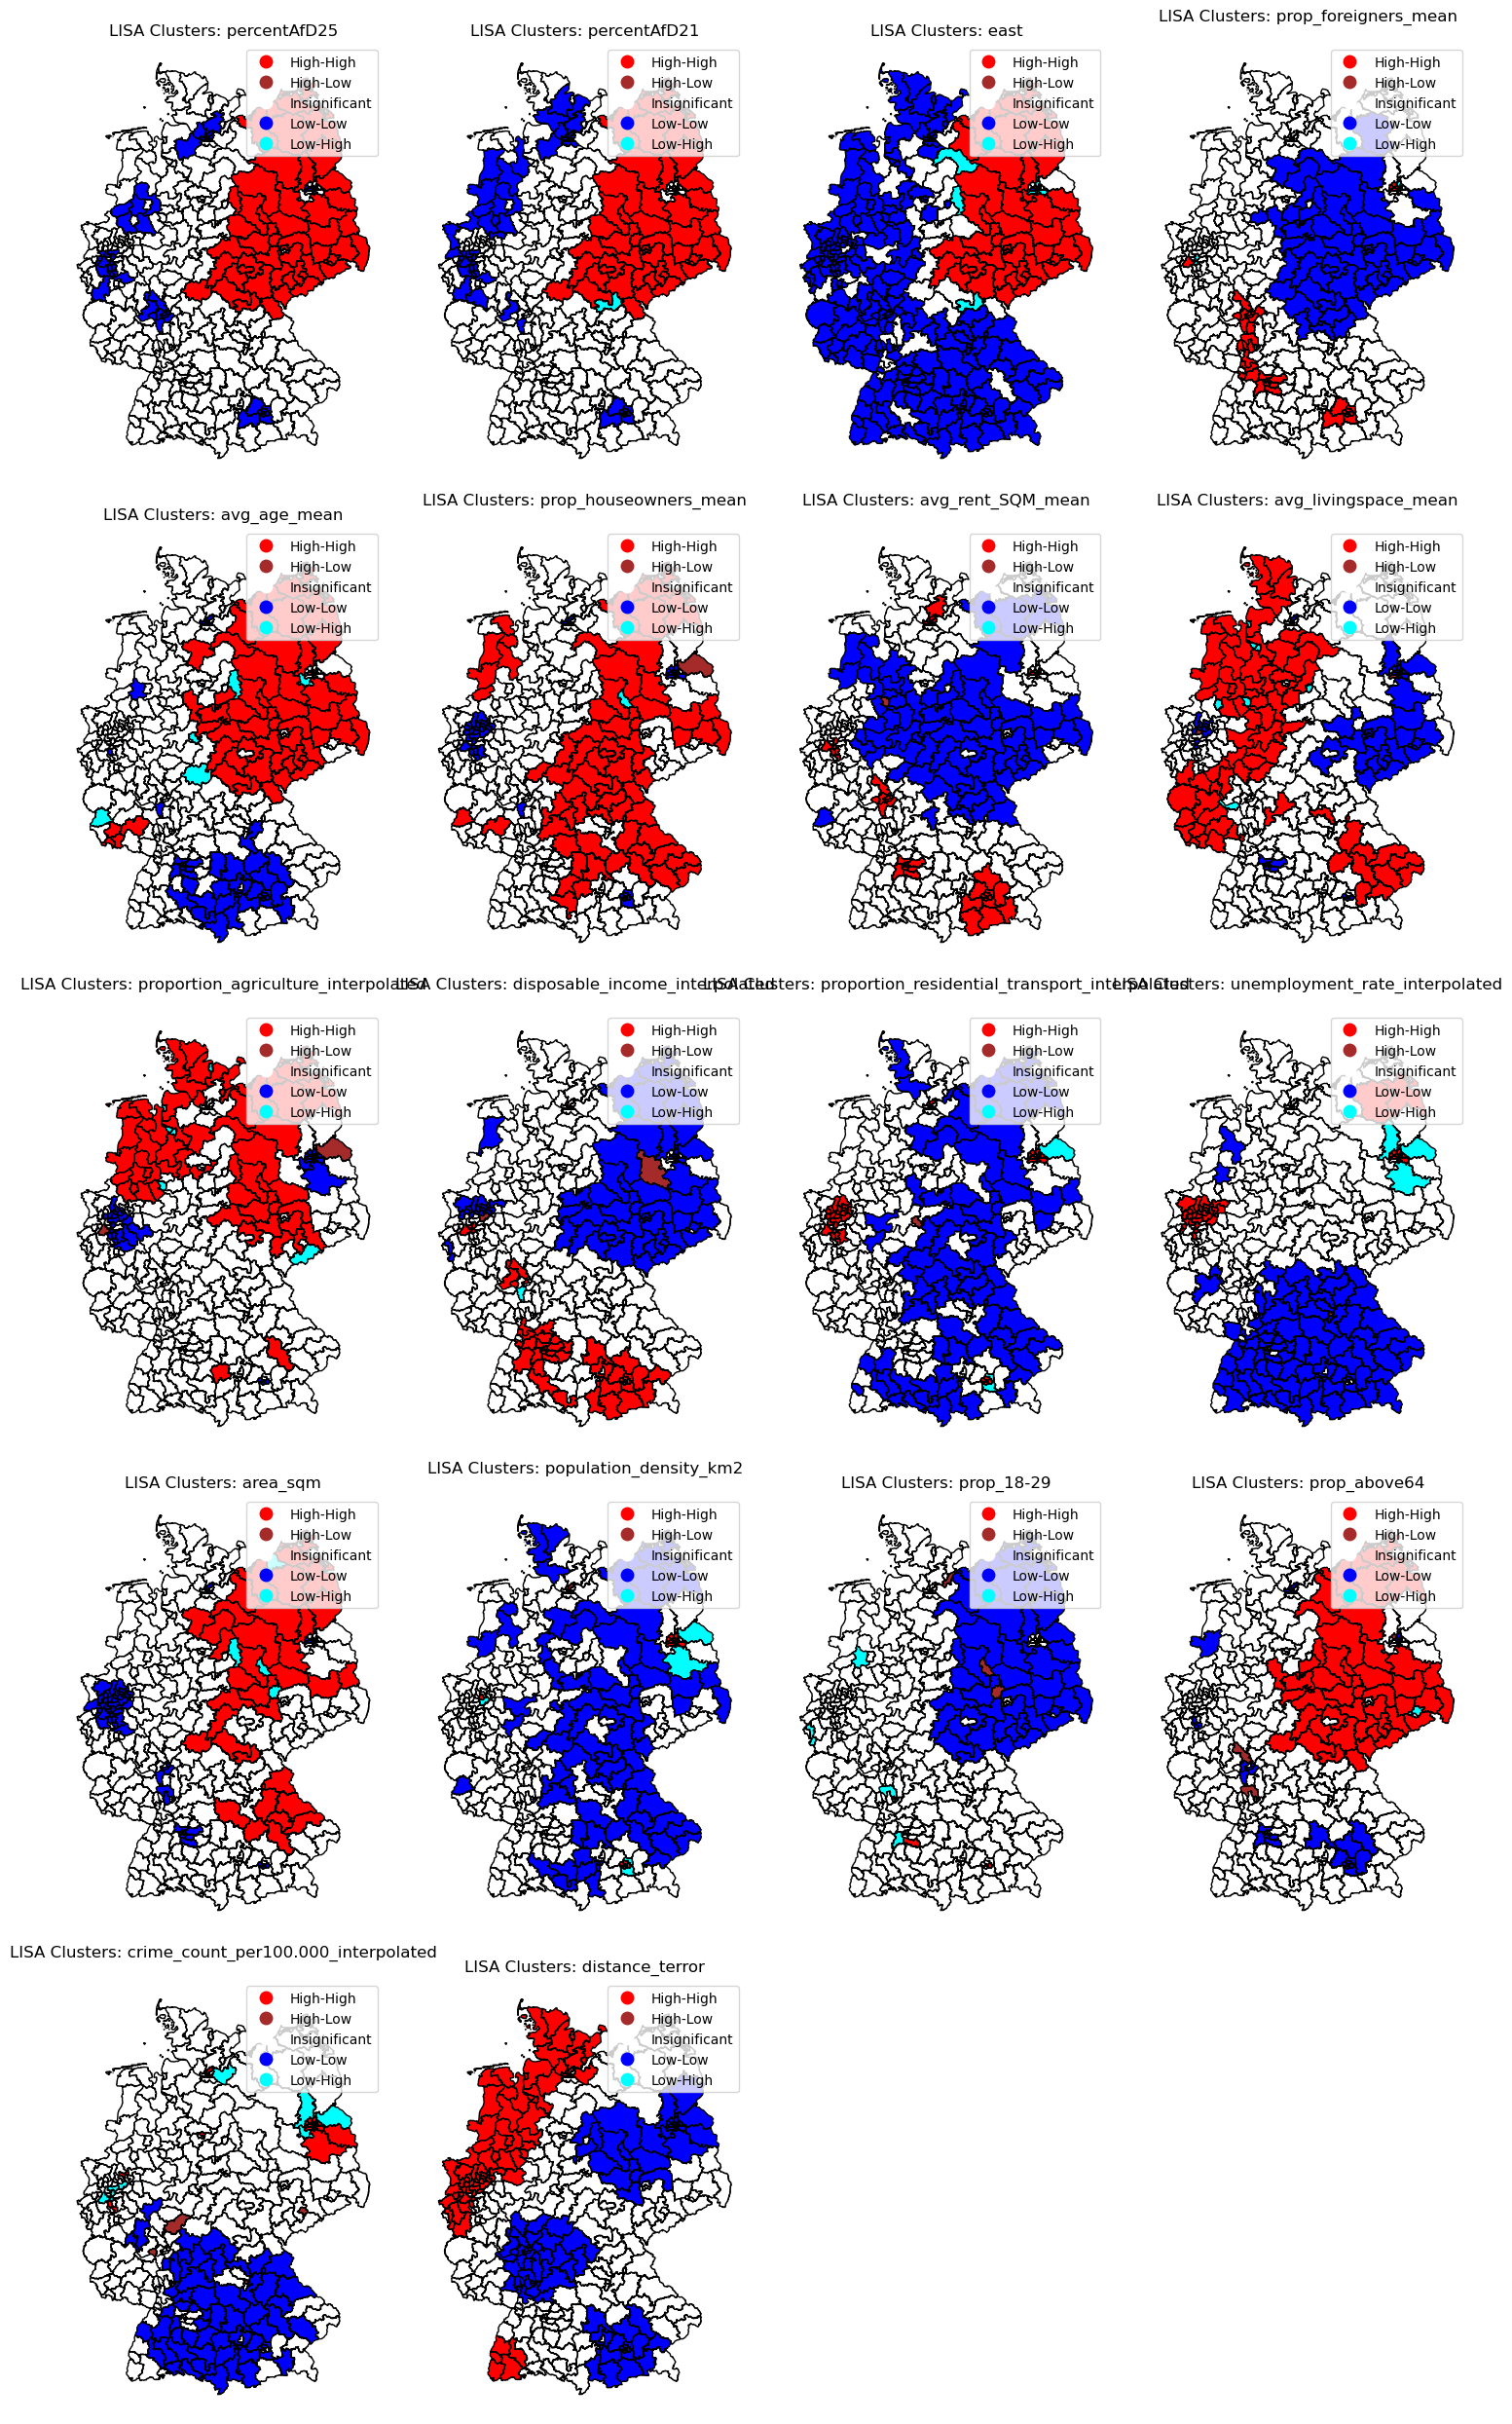

In [ ]:
pd.options.mode.chained_assignment = None

def classify_and_plot_local_clusters(df, column, ax):
    """
    Compute LISA, classify results into clusters, and plot clusters in the given axis.

    :param df: GeoDataFrame
    :param column: Column name as a string
    :param ax: Matplotlib axis to plot the results
    """

    # Compute Local Moran’s I
    moran_local = Moran_Local(df[column], w)

    # Store results in the dataframe
    df["LISA_I"] = moran_local.Is  # Local Moran's I values
    df["p_value"] = moran_local.p_sim  # P-values

    significance_level = 0.05
    mean_val = df[column].mean()

    def classify_cluster(row):
        column_value = df.loc[row.name, column]
        if row['p_value'] > significance_level:
            return "Insignificant"
        elif row['LISA_I'] >= 0 and column_value >= mean_val:
            return "High-High"
        elif row['LISA_I'] >= 0 and column_value < mean_val:
            return "Low-Low"
        elif row['LISA_I'] < 0 and column_value >= mean_val:
            return "High-Low"
        elif row['LISA_I'] < 0 and column_value < mean_val:
            return "Low-High"
        return "Insignificant"

    # Apply classification
    df['coType'] = df.apply(classify_cluster, axis=1)

    # Define color mapping
    color_map = {
        "High-High": "red",
        "High-Low": "brown",
        "Insignificant": "white",
        "Low-Low": "blue",
        "Low-High": "cyan"
    }

    # Set categorical order
    df['coType'] = pd.Categorical(df['coType'], categories=color_map.keys())

    # Plot
    df.plot(column='coType', cmap=ListedColormap(color_map.values()), legend=True, ax=ax, categorical=True, edgecolor="black")
    ax.set_title(f"LISA Clusters: {column}")
    ax.axis("off")  # Hide axes for cleaner plots

# Set number of rows and columns
rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 25))
axes = axes.flatten()  # Flatten for easy iteration

# Loop through the first 16 variables and plot
for i, variable in enumerate(numeric_analysis_vars[:17]):
    classify_and_plot_local_clusters(df_short, column=variable, ax=axes[i])

# Remove any unused subplots (if fewer than 16 variables)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()